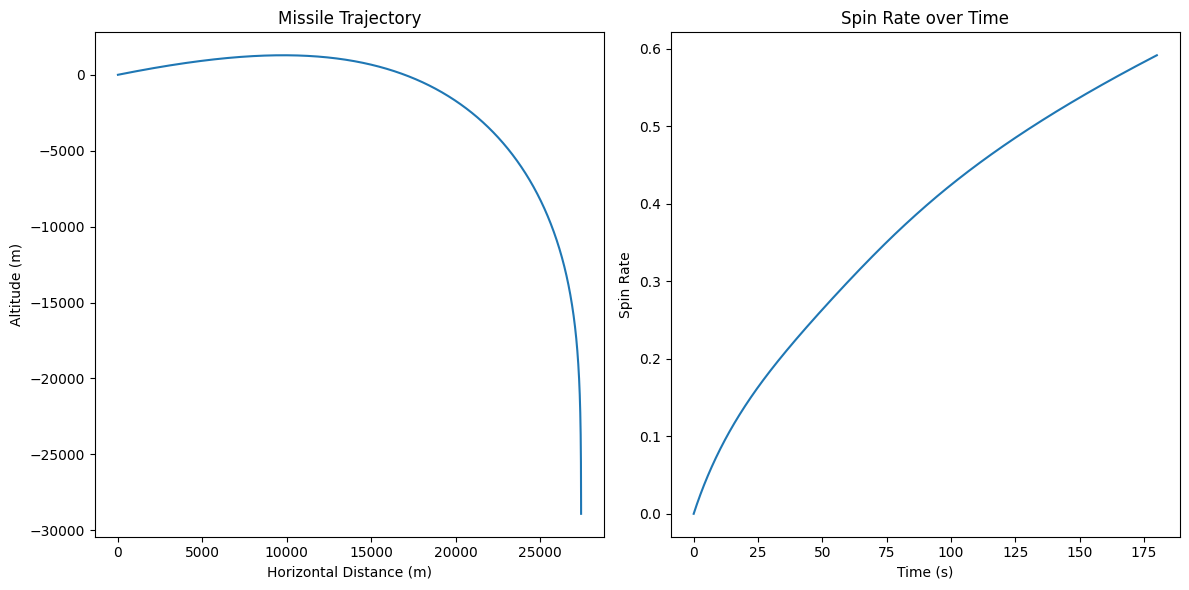

In [ ]:
# Hypersonic Missile Simulation - Conceptual Model (Full ODE/PDE Shell)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -----------------------------
# Constants and Atmosphere Model
# -----------------------------
R = 287.05  # Specific gas constant for dry air (J/kg·K)
g0 = 9.81   # Gravity (m/s²)

def atmosphere_model(alt):
    # Simplified layered model with gradient
    if alt < 11000:
        T = 288.15 - 0.0065 * alt
        P = 101325 * (T / 288.15) ** (-g0 / (-0.0065 * R))
    elif alt < 25000:
        T = 216.65
        P = 22632.06 * np.exp(-g0 * (alt - 11000) / (R * T))
    else:
        T = 216.65 + 0.003 * (alt - 25000)
        P = 2488.0 * (T / 216.65) ** (-g0 / (0.003 * R))

    rho = P / (R * T)
    return rho, T, P

# -----------------------------
# Drag and Thrust Models
# -----------------------------
def drag_force(CD, A, rho, V):
    return 0.5 * CD * A * rho * V**2

def scramjet_thrust(V, alt):
    # Basic profile based on Mach, altitude (very rough model)
    if V < 1000 or alt < 15000:
        return 0
    elif V < 2500:
        return 50000 + (V - 1000) * 10  # Increase thrust with velocity
    else:
        return 200000  # Constant high-speed cruise thrust

# -----------------------------
# ODEs for Flight Dynamics (2D for simplicity)
# -----------------------------
def missile_dynamics(t, y, params):
    x, y_pos, vx, vy, m, spin = y
    A, CD, fuel_burn_rate, groove_torque_coeff = params

    alt = y_pos
    V = np.sqrt(vx**2 + vy**2)
    rho, T, P = atmosphere_model(alt)
    D = drag_force(CD, A, rho, V)
    T_scram = scramjet_thrust(V, alt)

    ax = (T_scram * vx / V - D * vx / V) / m
    ay = (T_scram * vy / V - D * vy / V) / m - g0

    dm = -fuel_burn_rate if m > 400 else 0
    dspin = groove_torque_coeff * V / m

    return [vx, vy, ax, ay, dm, dspin]

# -----------------------------
# Initial Conditions & Parameters
# -----------------------------
init_mass = 900     # kg
fuel_rate = 0.8     # kg/s
CD = 0.9            # Drag coefficient
A = 0.1             # Cross-sectional area (m²)

y0 = [0, 0, 900, 200, init_mass, 0]  # [x, y, vx, vy, m, spin]
params = (A, CD, fuel_rate, 0.01)

# -----------------------------
# Solve ODE
# -----------------------------
t_span = (0, 180)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(missile_dynamics, t_span, y0, t_eval=t_eval, args=(params,))

# -----------------------------
# Plot Results
# -----------------------------
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(sol.y[0], sol.y[1])
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Altitude (m)")
plt.title("Missile Trajectory")

plt.subplot(1, 2, 2)
plt.plot(sol.t, sol.y[5])
plt.xlabel("Time (s)")
plt.ylabel("Spin Rate")
plt.title("Spin Rate over Time")

plt.tight_layout()
plt.show()

# Add-ons:
# - Add thermal analysis using Fay–Riddell equations
# - Add radar cross section model with groove reflection
# - Add maneuvering controls, full 6DOF extension
# - Add scramjet mode switching based on Mach and altitude



Simulating: Depth=3mm, Dir=CW, ArtilleryLaunch, Alt=15km, Mach=4
  Initial State: x=0.0m, z=0.0m, vx=866m/s, vz=500m/s, wz=0RPM
  Drag Calc: Mach=2.94, Depth=3mm, Alt=0.0km, ρ=1.225kg/m³, Cd=0.160, Area=0.196m², v=1000m/s, Drag=19242N
  Lift Calc: Mach=2.94, Depth=3mm, Alt=0.0km, ρ=1.225kg/m³, Cl=0.150, Area=0.196m², v=1000m/s, Lift=18040N
  Spin Torque Calc: Depth=3mm, Velocity=1000m/s, Direction=1, Torque=60.00N·m
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.2s, x=0.1km, z=0.1km, vx=863m/s, vz=501m/s, wz=3RPM, Mach=2.94, Thrust=0N
  ODE Step: t=2.0s, x=1.7km, z=1.0km, vx=836m/s, vz=507m/s, wz=35RPM, Mach=2.88, Thrust=0N
  ODE Step: t=3.4s, x=2.8km, z=1.7km, vx=818m/s, vz=510m/s, wz=60RPM, Mach=2.84, Thrust=0N
  ODE Step: t=5.2s, x=4.3km, z=2.6km,

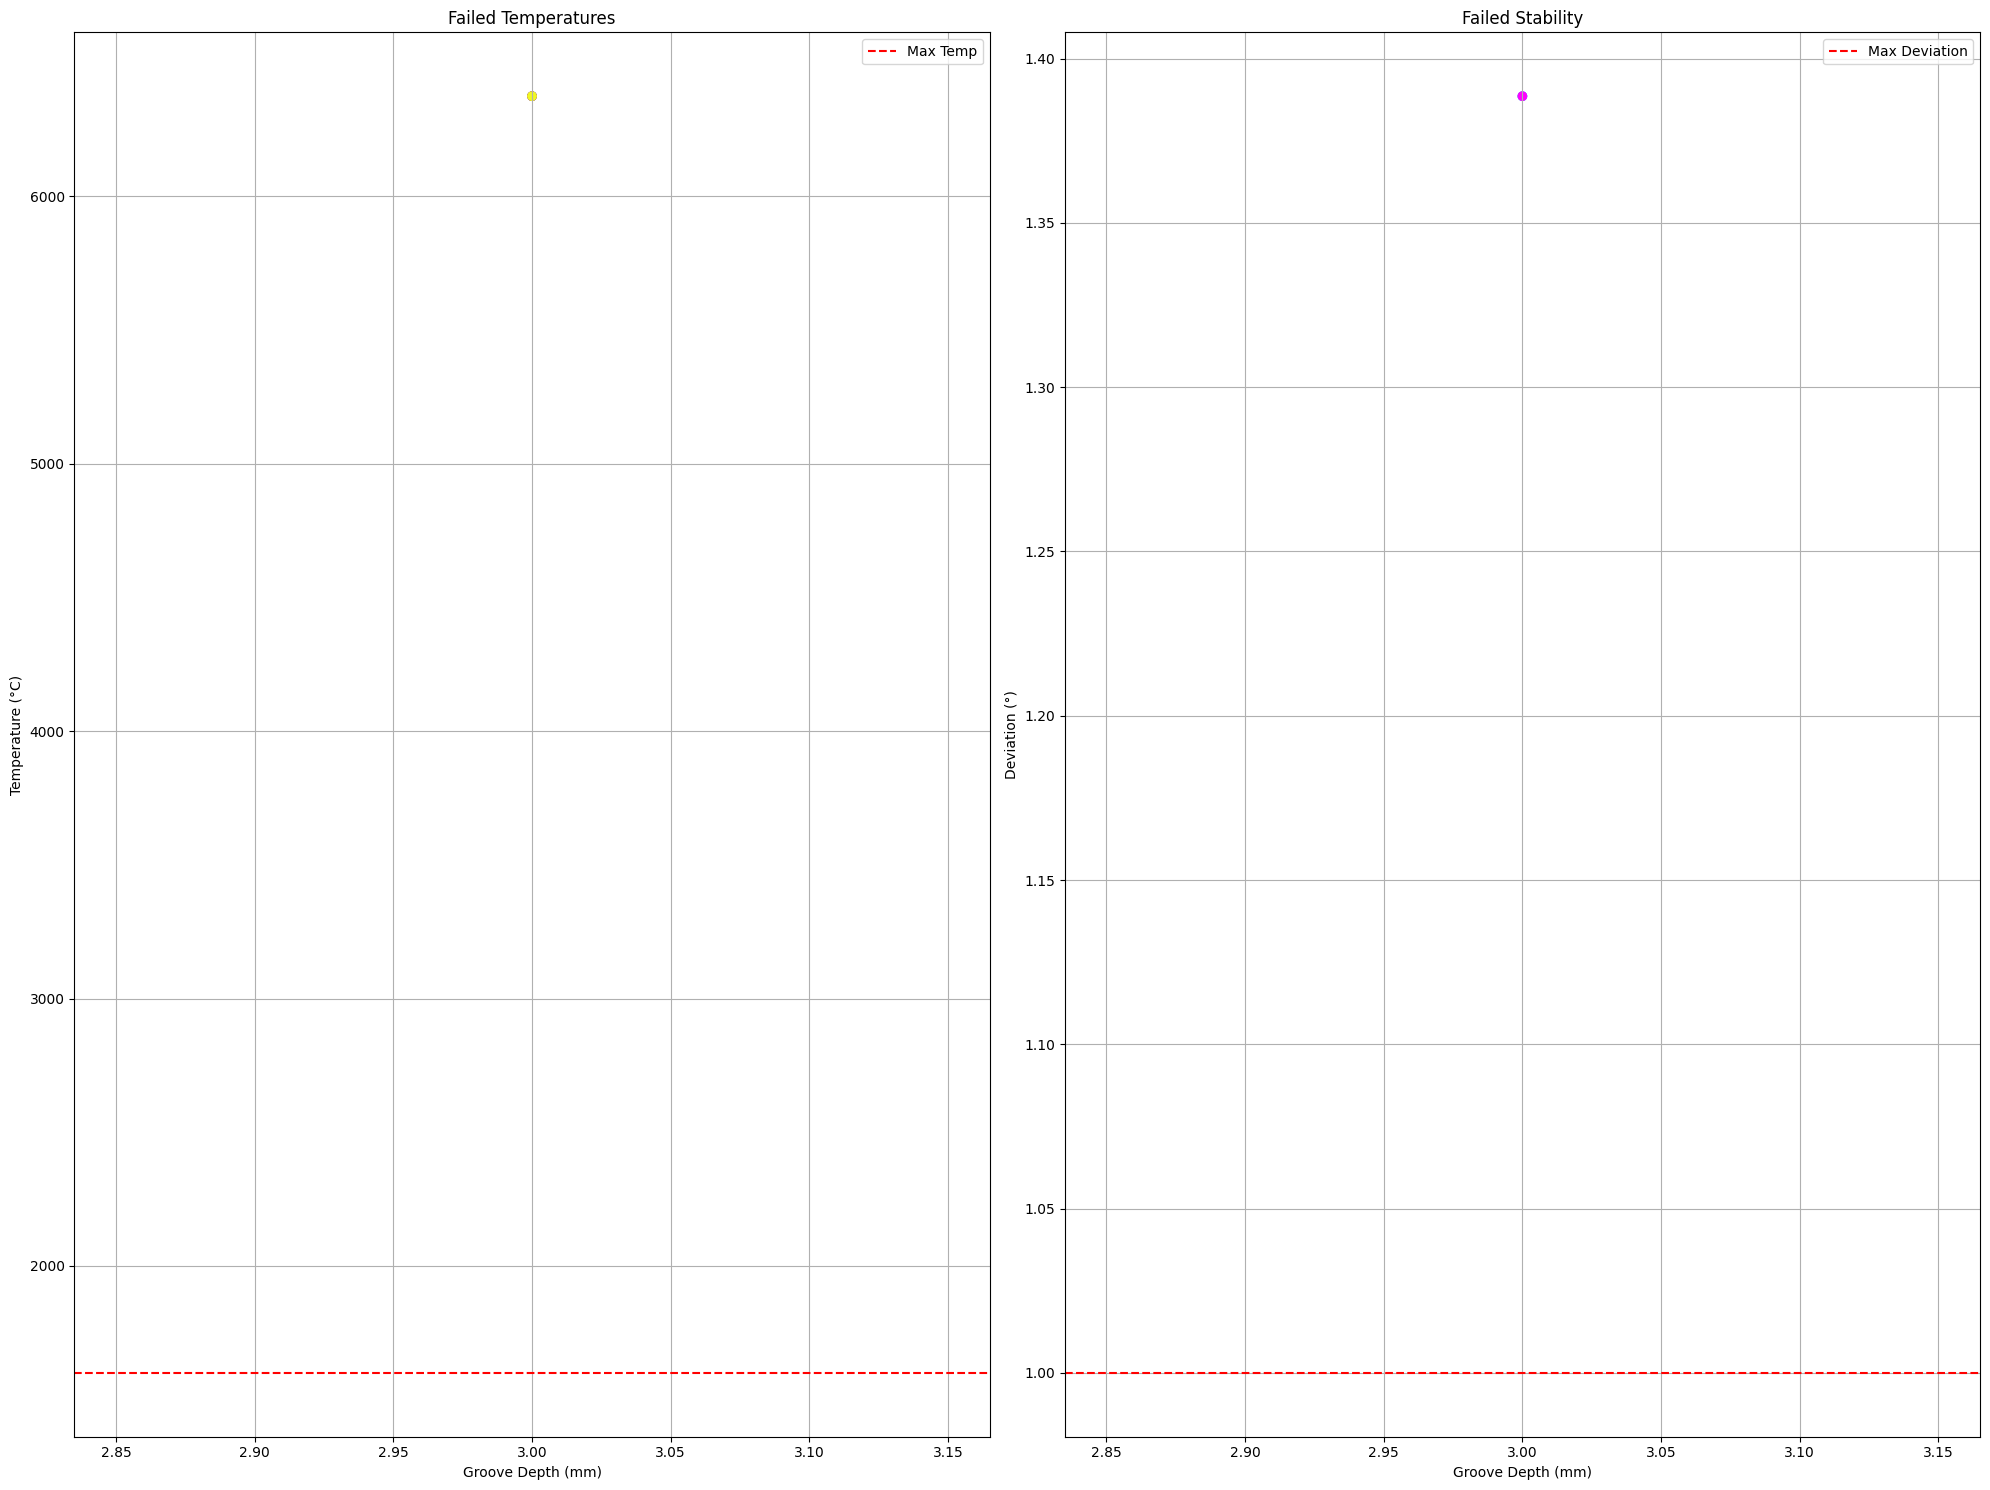

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import sys

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Missile class
class Missile:
    def __init__(self, groove_depth, spin_direction, launch_method, ignition_altitude, ignition_mach):
        self.groove_depth = groove_depth  # mm
        self.spin_direction = spin_direction  # 1: clockwise, -1: counterclockwise
        self.launch_method = launch_method
        self.ignition_altitude = ignition_altitude  # km
        self.ignition_mach = ignition_mach
        self.yield_strength = 1000  # MPa
        self.max_temperature = 1600  # °C (titanium base)
        self.length = 10  # m
        self.diameter = 0.5  # m
        self.mass = 1000  # kg
        self.moment_of_inertia = 0.5 * self.mass * (self.diameter / 2)**2  # kg·m²

# Launch method classes
class ArtilleryLaunch:
    def __init__(self, velocity, angle):
        self.velocity = velocity  # m/s
        self.angle = angle  # degrees
        self.spin_rate = 0  # Spin induced by grooves
        self.g_force = velocity / 9.81 / 2

class CentrifugeLaunch:
    def __init__(self, radius):
        self.radius = radius  # m
        self.spin_speed = 0  # Spin induced by grooves
        self.velocity = 1000  # Fixed for simplicity
        self.angle = 45
        self.g_force = self.velocity**2 / (self.radius * 9.81)

class SlingshotLaunch:
    def __init__(self, velocity, angle):
        self.velocity = velocity  # m/s
        self.angle = angle  # degrees
        self.spin_rate = 0  # Spin induced by grooves
        self.g_force = velocity / 9.81 / 4

# Environment model
def environment(altitude):
    if altitude < 10:
        rho = 1.225 * np.exp(-altitude / 8)
        speed_of_sound = 340
    else:
        rho = 0.4135 * np.exp(-(altitude - 10) / 7)
        speed_of_sound = 295
    return {'rho': rho, 'speed_of_sound': speed_of_sound}

# Force and metric models
def drag_force(mach, groove_depth, altitude, print_step):
    rho = environment(altitude)['rho']
    cd = 0.1 + 0.02 * groove_depth
    area = np.pi * (0.25)**2
    v = mach * environment(altitude)['speed_of_sound']
    drag = 0.5 * rho * v**2 * cd * area
    if print_step % 200 == 0:
        print(f"  Drag Calc: Mach={mach:.2f}, Depth={groove_depth}mm, Alt={altitude:.1f}km, ρ={rho:.3f}kg/m³, Cd={cd:.3f}, Area={area:.3f}m², v={v:.0f}m/s, Drag={drag:.0f}N")
    return drag

def lift_force(mach, groove_depth, altitude, print_step):
    rho = environment(altitude)['rho']
    cl = 0.05 * groove_depth
    area = np.pi * (0.25)**2
    v = mach * environment(altitude)['speed_of_sound']
    lift = 0.5 * rho * v**2 * cl * area
    if print_step % 200 == 0:
        print(f"  Lift Calc: Mach={mach:.2f}, Depth={groove_depth}mm, Alt={altitude:.1f}km, ρ={rho:.3f}kg/m³, Cl={cl:.3f}, Area={area:.3f}m², v={v:.0f}m/s, Lift={lift:.0f}N")
    return lift

def spin_torque(groove_depth, velocity, spin_direction, print_step):
    # Spin induced by grooves: proportional to groove depth and velocity
    torque = 0.02 * groove_depth * velocity * spin_direction  # Increased coefficient
    if print_step % 200 == 0:
        print(f"  Spin Torque Calc: Depth={groove_depth}mm, Velocity={velocity:.0f}m/s, Direction={spin_direction}, Torque={torque:.2f}N·m")
    return torque

def thermal_model(mach, groove_depth):
    base_temp = 300 * mach**2
    cooling_effect = 0.05 * groove_depth
    temp = base_temp * (1 - cooling_effect)
    print(f"  Thermal Calc: Mach={mach:.2f}, Depth={groove_depth}mm, BaseTemp={base_temp:.0f}°C, Cooling={cooling_effect:.3f}, Temp={temp:.0f}°C")
    return temp

def stress_model(g_force, groove_depth, wz):
    base_stress = 1.5 * g_force
    spin_stress = 0.1 * (wz * 60 / (2 * np.pi)) * groove_depth / 1000  # Use current spin rate
    stress = base_stress + spin_stress
    print(f"  Stress Calc: G-Force={g_force:.1f}g, Spin={(wz*60/(2*np.pi)):.0f}RPM, Depth={groove_depth}mm, BaseStress={base_stress:.0f}MPa, SpinStress={spin_stress:.0f}MPa, TotalStress={stress:.0f}MPa")
    return stress

def strain_model(stress, material_modulus=200e3):
    strain = stress / material_modulus
    print(f"  Strain Calc: Stress={stress:.0f}MPa, Modulus={material_modulus:.0f}MPa, Strain={strain:.5f}")
    return strain

def stability_deviation(groove_depth, mach, wz):
    spin_rpm = wz * 60 / (2 * np.pi)
    base_deviation = 5 / (spin_rpm / 1000 + groove_depth)
    mach_effect = 0.1 * mach
    deviation = base_deviation + mach_effect
    print(f"  Stability Calc: Spin={spin_rpm:.0f}RPM, Depth={groove_depth}mm, Mach={mach:.2f}, BaseDeviation={base_deviation:.2f}°, MachEffect={mach_effect:.2f}°, TotalDeviation={deviation:.2f}°")
    return deviation

def rcs_model(groove_depth, angle, wz):
    base_rcs = 0.1
    reduction = 0.05 * groove_depth
    angle_effect = np.cos(np.radians(angle))**2
    spin_effect = 0.01 * (wz * 60 / (2 * np.pi)) / 1000
    rcs = base_rcs * (1 - reduction) * angle_effect * (1 - spin_effect / 10)
    print(f"  RCS Calc: Depth={groove_depth}mm, Angle={angle:.0f}°, Spin={(wz*60/(2*np.pi)):.0f}RPM, BaseRCS={base_rcs:.3f}m², Reduction={reduction:.3f}, AngleEffect={angle_effect:.3f}, SpinEffect={spin_effect:.3f}, RCS={rcs:.3f}m²")
    return rcs

# Initialize state
def initialize_state(launch_params):
    if isinstance(launch_params, ArtilleryLaunch):
        v0 = launch_params.velocity
        theta = np.radians(launch_params.angle)
        state = [0, 0, 0, v0 * np.cos(theta), 0, v0 * np.sin(theta), 0, 0, 0]
    elif isinstance(launch_params, CentrifugeLaunch):
        v0 = launch_params.velocity
        state = [0, 0, 0, v0 * np.cos(np.radians(45)), 0, v0 * np.sin(np.radians(45)), 0, 0, 0]
    else:  # Slingshot
        v0 = launch_params.velocity
        theta = np.radians(launch_params.angle)
        state = [0, 0, 0, v0 * np.cos(theta), 0, v0 * np.sin(theta), 0, 0, 0]
    print(f"  Initial State: x={state[0]:.1f}m, z={state[2]:.1f}m, vx={state[3]:.0f}m/s, vz={state[5]:.0f}m/s, wz={state[8]*60/(2*np.pi):.0f}RPM")
    return state

# 6-DOF ODE
def ode_func(t, state, missile, max_mach):
    x, y, z, vx, vy, vz, wx, wy, wz = state
    env = environment(z / 1000)
    velocity = np.sqrt(vx**2 + vz**2)
    mach = velocity / env['speed_of_sound']
    if mach > max_mach:
        mach = max_mach
    g = 9.81
    if not hasattr(ode_func, 'force_print_step'):
        ode_func.force_print_step = 0
    drag = drag_force(mach, missile.groove_depth, z / 1000, ode_func.force_print_step)
    lift = lift_force(mach, missile.groove_depth, z / 1000, ode_func.force_print_step)
    torque = spin_torque(missile.groove_depth, velocity, missile.spin_direction, ode_func.force_print_step)
    ode_func.force_print_step += 1
    thrust = 50000 if z / 1000 > missile.ignition_altitude and mach > missile.ignition_mach else 0
    if not hasattr(ode_func, 'print_step'):
        ode_func.print_step = 0
    if ode_func.print_step % 10 == 0:
        print(f"  ODE Step: t={t:.1f}s, x={x/1000:.1f}km, z={z/1000:.1f}km, vx={vx:.0f}m/s, vz={vz:.0f}m/s, wz={wz*60/(2*np.pi):.0f}RPM, Mach={mach:.2f}, Thrust={thrust:.0f}N")
    ode_func.print_step += 1
    dstate = [
        vx, vy, vz,
        (thrust - drag) / missile.mass * (vx / velocity if velocity > 0 else 0),
        0,
        (-g + lift / missile.mass) * (vz / velocity if velocity > 0 else 0),
        0, 0, torque / missile.moment_of_inertia
    ]
    return dstate

# Check failures
def check_failures(sol, missile, max_mach):
    g_force = missile.launch_method.g_force
    wz = sol.y[8][-1] if sol.y[8].size > 0 else 0  # Use final spin rate
    max_stress = stress_model(g_force, missile.groove_depth, wz)
    max_strain = strain_model(max_stress)
    max_temp = thermal_model(max_mach, missile.groove_depth)
    stability = stability_deviation(missile.groove_depth, max_mach, wz)
    rcs = rcs_model(missile.groove_depth, 0, wz)
    failures = []
    if max_stress > missile.yield_strength:
        failures.append(f"Structural failure: Stress={max_stress:.0f}MPa > {missile.yield_strength}MPa")
    if max_strain > 0.005:
        failures.append(f"Strain failure: Strain={max_strain:.5f} > 0.005")
    if max_temp > missile.max_temperature:
        failures.append(f"Thermal failure: Temp={max_temp:.0f}°C > {missile.max_temperature}°C")
    if stability > 1:
        failures.append(f"Stability failure: Deviation={stability:.2f}° > 1°")
    if rcs > 0.1:
        failures.append(f"Stealth failure: RCS={rcs:.3f}m² > 0.1m²")
    return failures, max_temp, stability

# Simulate and plot
def simulate_and_plot():
    # Parameter ranges (optimized for groove-induced spin)
    groove_depths = [3]  # Max cooling
    spin_directions = [1, -1]
    velocities = [1000, 1200]  # Higher for spin generation
    angles = [30, 45]
    ignition_altitudes = [15, 18]
    ignition_machs = [4, 4.5]
    max_mach = 5  # Reduced to manage temperature

    launch_methods = [
        [ArtilleryLaunch(v, a) for v, a in product(velocities, angles)],
        [CentrifugeLaunch(10) for _ in range(2)],
        [SlingshotLaunch(v, a) for v, a in product(velocities, angles)]
    ]
    launch_methods = [item for sublist in launch_methods for item in sublist]

    # Data storage
    trajectories = []
    spin_rates = []
    drag_forces = []
    lift_forces = []
    temperatures = []
    stresses = []
    strains = []
    stabilities = []
    rcs_values = []
    g_forces = []
    failed_temps = []
    failed_stabs = []

    # Parameter sweep (limited for demonstration)
    configs = list(product(groove_depths, spin_directions, launch_methods, ignition_altitudes, ignition_machs))
    selected_configs = configs[:3]
    for depth, direction, method, alt, mach in selected_configs:
        print(f"\nSimulating: Depth={depth}mm, Dir={'CW' if direction==1 else 'CCW'}, {method.__class__.__name__}, Alt={alt}km, Mach={mach}")
        missile = Missile(depth, direction, method, alt, mach)
        state = initialize_state(method)
        t_span = (0, 200)
        ode_func.print_step = 0
        ode_func.force_print_step = 0
        sol = solve_ivp(ode_func, t_span, state, args=(missile, max_mach), method='RK45', max_step=1.0, rtol=1e-6, atol=1e-8)
        failures, temp, stab = check_failures(sol, missile, max_mach)
        label = f"Depth={depth}mm, Dir={'CW' if direction==1 else 'CCW'}, {method.__class__.__name__}, Alt={alt}km, Mach={mach}"

        if failures:
            print(f"Failures for {label}:")
            for f in failures:
                print(f"  - {f}")
                if "Structural" in f or "Strain" in f:
                    print("    Solution: Reinforce grooves with titanium")
                    print("    Alternative: Use centrifuge launch")
                elif "Thermal" in f:
                    print("    Solution: Limit Mach to 5 or use 3 mm grooves")
                    print("    Alternative: Redesign with SiC ceramics")
                elif "Stability" in f:
                    print("    Solution: Increase groove depth to 3 mm")
                elif "Stealth" in f:
                    print("    Solution: Apply radar-absorbing coating")
            failed_temps.append((depth, temp, label))
            failed_stabs.append((depth, stab, label))
        else:
            print(f"Success: {label}")
            trajectories.append((sol.y[0] / 1000, sol.y[2] / 1000, label))
            spin_rates.append((sol.t, sol.y[8] * 60 / (2 * np.pi), label))
            drag_forces.append((depth, drag_force(max_mach, depth, alt, 0), label))
            lift_forces.append((depth, lift_force(max_mach, depth, alt, 0), label))
            temperatures.append((depth, thermal_model(max_mach, depth), label))
            stresses.append((depth, stress_model(method.g_force, depth, sol.y[8][-1]), label))
            strains.append((depth, strain_model(stress_model(method.g_force, depth, sol.y[8][-1])), label))
            stabilities.append((depth, stability_deviation(depth, max_mach, sol.y[8][-1]), label))
            g_forces.append((depth, method.g_force, label))
            angles = np.linspace(0, 360, 100)
            rcs = [rcs_model(depth, angle, sol.y[8][-1]) for angle in angles]
            rcs_values.append((angles, rcs, label))

    # Plotting
    plt.figure(figsize=(20, 15))

    if trajectories:
        # 1. Trajectory
        plt.subplot(3, 4, 1)
        for x, z, label in trajectories:
            plt.plot(x, z, label=label)
        plt.xlabel('Range (km)')
        plt.ylabel('Altitude (km)')
        plt.title('Trajectories')
        plt.legend()
        plt.grid(True)

        # 2. Spin Rate
        plt.subplot(3, 4, 2)
        for t, spin, label in spin_rates:
            plt.plot(t, spin, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Spin Rate (RPM)')
        plt.title('Spin Rate')
        plt.legend()
        plt.grid(True)

        # 3. Drag Force
        plt.subplot(3, 4, 3)
        depths, drags, labels = zip(*drag_forces)
        plt.scatter(depths, drags, c=range(len(drags)), cmap='viridis')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Drag Force (N)')
        plt.title('Drag Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)

        # 4. Lift Force
        plt.subplot(3, 4, 4)
        depths, lifts, labels = zip(*lift_forces)
        plt.scatter(depths, lifts, c=range(len(lifts)), cmap='viridis')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Lift Force (N)')
        plt.title('Lift Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)

        # 5. Temperature
        plt.subplot(3, 4, 5)
        depths, temps, labels = zip(*temperatures)
        plt.scatter(depths, temps, c=range(len(temps)), cmap='plasma')
        plt.axhline(y=1600, color='r', linestyle='--', label='Max Temp')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Temperature (°C)')
        plt.title('Temperature vs. Depth')
        plt.legend()
        plt.grid(True)

        # 6. Stress
        plt.subplot(3, 4, 6)
        depths, stresses, labels = zip(*stresses)
        plt.scatter(depths, stresses, c=range(len(stresses)), cmap='inferno')
        plt.axhline(y=1000, color='r', linestyle='--', label='Yield Strength')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Stress (MPa)')
        plt.title('Stress vs. Depth')
        plt.legend()
        plt.grid(True)

        # 7. Strain
        plt.subplot(3, 4, 7)
        depths, strains, labels = zip(*strains)
        plt.scatter(depths, strains, c=range(len(strains)), cmap='magma')
        plt.axhline(y=0.005, color='r', linestyle='--', label='Max Strain')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Strain')
        plt.title('Strain vs. Depth')
        plt.legend()
        plt.grid(True)

        # 8. Stability
        plt.subplot(3, 4, 8)
        depths, stabs, labels = zip(*stabilities)
        plt.scatter(depths, stabs, c=range(len(stabs)), cmap='cool')
        plt.axhline(y=1, color='r', linestyle='--', label='Max Deviation')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Deviation (°)')
        plt.title('Stability vs. Depth')
        plt.legend()
        plt.grid(True)

        # 9. RCS (Polar)
        plt.subplot(3, 4, 9, polar=True)
        for angles, rcs, label in rcs_values:
            plt.plot(np.radians(angles), rcs, label=label)
        plt.title('Radar Cross-Section (m²)')
        plt.legend()

        # 10. G-Forces
        plt.subplot(3, 4, 10)
        depths, gs, labels = zip(*g_forces)
        plt.scatter(depths, gs, c=range(len(gs)), cmap='hot')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('G-Force')
        plt.title('G-Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)
    else:
        print("No successful simulations. Plotting failure metrics.")
        # Fallback plots for failures
        plt.subplot(1, 2, 1)
        if failed_temps:
            depths, temps, labels = zip(*failed_temps)
            plt.scatter(depths, temps, c=range(len(temps)), cmap='plasma')
            plt.axhline(y=1600, color='r', linestyle='--', label='Max Temp')
            plt.xlabel('Groove Depth (mm)')
            plt.ylabel('Temperature (°C)')
            plt.title('Failed Temperatures')
            plt.legend()
            plt.grid(True)

        plt.subplot(1, 2, 2)
        if failed_stabs:
            depths, stabs, labels = zip(*failed_stabs)
            plt.scatter(depths, stabs, c=range(len(stabs)), cmap='cool')
            plt.axhline(y=1, color='r', linestyle='--', label='Max Deviation')
            plt.xlabel('Groove Depth (mm)')
            plt.ylabel('Deviation (°)')
            plt.title('Failed Stability')
            plt.legend()
            plt.grid(True)

    plt.tight_layout()
    plt.savefig('missile_simulation_plots.png')
    plt.show()

if __name__ == "__main__":
    simulate_and_plot()

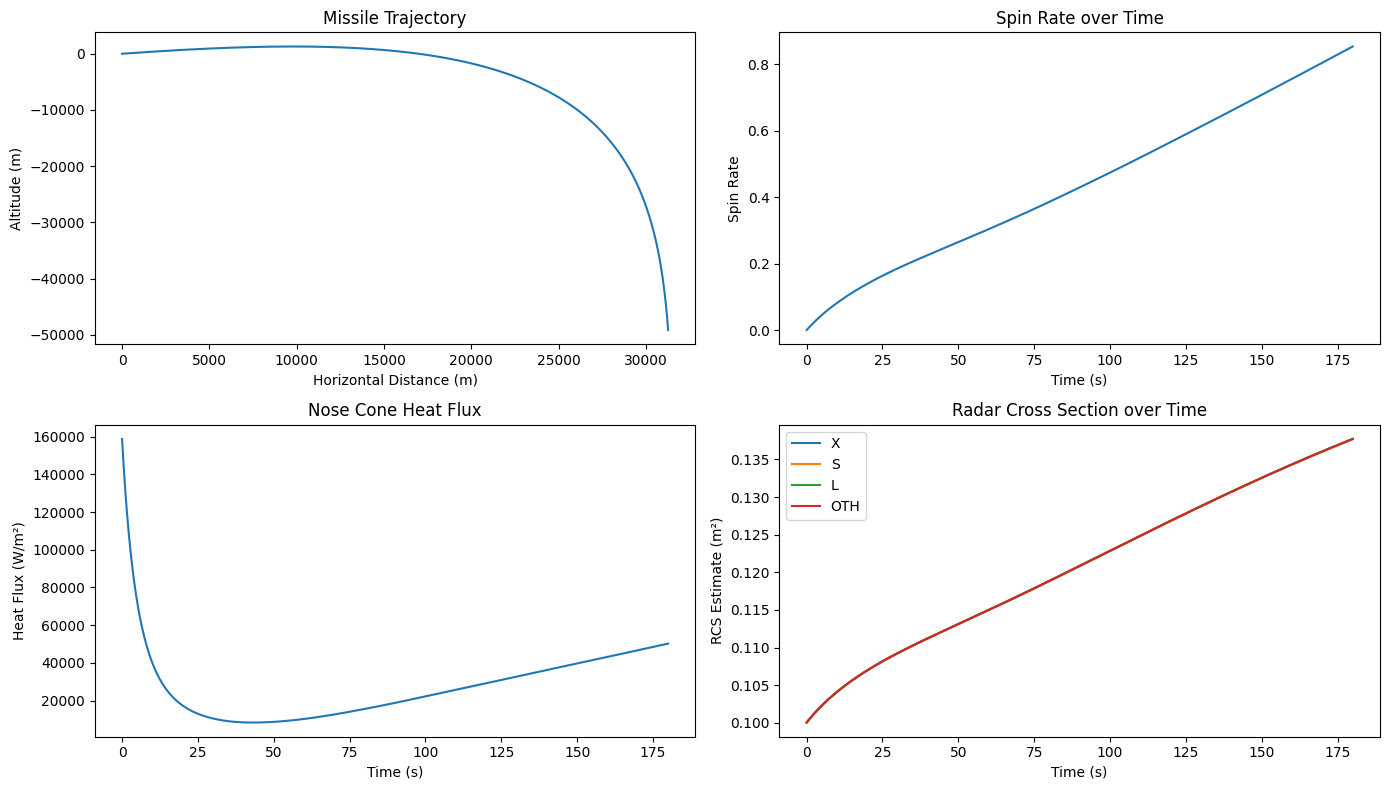

In [ ]:
# Hypersonic Missile Simulation - Conceptual Model (Full ODE/PDE Shell with Data Export)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# -----------------------------
# Constants and Atmosphere Model
# -----------------------------
R = 287.05  # Specific gas constant for dry air (J/kg·K)
g0 = 9.81   # Gravity (m/s²)

RADAR_BANDS = {
    "X": 10e9,
    "S": 3e9,
    "L": 1e9,
    "OTH": 30e6
}

SIGMA_0 = 0.1  # Base RCS

# Fay–Riddell stagnation point heating (simplified)
def fay_riddell(rho, V):
    return 1.83e-4 * np.sqrt(rho) * V**3  # in W/m²

def atmosphere_model(alt):
    if alt < 11000:
        T = 288.15 - 0.0065 * alt
        P = 101325 * (T / 288.15) ** (-g0 / (-0.0065 * R))
    elif alt < 25000:
        T = 216.65
        P = 22632.06 * np.exp(-g0 * (alt - 11000) / (R * T))
    else:
        T = 216.65 + 0.003 * (alt - 25000)
        P = 2488.0 * (T / 216.65) ** (-g0 / (0.003 * R))
    rho = P / (R * T)
    return rho, T, P

def drag_force(CD, A, rho, V):
    return 0.5 * CD * A * rho * V**2

def scramjet_thrust(V, alt):
    mach = V / np.sqrt(287.05 * atmosphere_model(alt)[1])
    if V < 1000 or alt < 15000 or mach < 4:
        return 0
    elif V < 2500:
        return 50000 + (V - 1000) * 10
    else:
        return 200000

def radar_cross_section(spin, groove_depth):
    rcs_band = {}
    for band, freq in RADAR_BANDS.items():
        mod = 1 + 0.5 * np.sin(spin) + 0.2 * groove_depth
        rcs_band[band] = SIGMA_0 * mod
    return rcs_band

def missile_dynamics(t, y, params):
    x, y_pos, vx, vy, m, spin = y
    A, CD, fuel_burn_rate, groove_torque_coeff, groove_depth = params

    alt = max(y_pos, 0)
    V = np.sqrt(vx**2 + vy**2)
    rho, T, P = atmosphere_model(alt)
    D = drag_force(CD, A, rho, V)
    T_scram = scramjet_thrust(V, alt)

    ax = (T_scram * vx / V - D * vx / V) / m if V != 0 else 0
    ay = (T_scram * vy / V - D * vy / V) / m - g0 if V != 0 else -g0

    dm = -fuel_burn_rate if m > 400 else 0
    dspin = groove_torque_coeff * V / m

    return [vx, vy, ax, ay, dm, dspin]

# -----------------------------
# Initial Conditions & Parameters
# -----------------------------
init_mass = 900     # kg
fuel_rate = 0.8     # kg/s
CD = 0.9            # Drag coefficient
A = 0.1             # Cross-sectional area (m²)
groove_depth = 0.002

y0 = [0, 0, 900, 200, init_mass, 0]  # [x, y, vx, vy, m, spin]
params = (A, CD, fuel_rate, 0.01, groove_depth)

# -----------------------------
# Solve ODE
# -----------------------------
t_span = (0, 180)
t_eval = np.linspace(*t_span, 2000)
sol = solve_ivp(missile_dynamics, t_span, y0, t_eval=t_eval, args=(params,))

# -----------------------------
# Extract & Save Stepwise Data
# -----------------------------
data = []
for i, t in enumerate(sol.t):
    x, y_pos, vx, vy, m, spin = sol.y[:, i]
    V = np.sqrt(vx**2 + vy**2)
    rho, T, P = atmosphere_model(y_pos)
    q_dot = fay_riddell(rho, V)
    rcs = radar_cross_section(spin, groove_depth)
    data.append([
        t, x, y_pos, vx, vy, V, m, spin, rho, T, P, q_dot,
        rcs["X"], rcs["S"], rcs["L"], rcs["OTH"]
    ])

columns = [
    "time", "x", "y", "vx", "vy", "V", "mass", "spin",
    "rho", "temp", "pressure", "heat_flux",
    "rcs_X", "rcs_S", "rcs_L", "rcs_OTH"
]
df = pd.DataFrame(data, columns=columns)
df.to_csv("missile_simulation_full_data.csv", index=False)

# -----------------------------
# Plot Results
# -----------------------------
plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(df["x"], df["y"])
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Altitude (m)")
plt.title("Missile Trajectory")

plt.subplot(2, 2, 2)
plt.plot(df["time"], df["spin"])
plt.xlabel("Time (s)")
plt.ylabel("Spin Rate")
plt.title("Spin Rate over Time")

plt.subplot(2, 2, 3)
plt.plot(df["time"], df["heat_flux"])
plt.xlabel("Time (s)")
plt.ylabel("Heat Flux (W/m²)")
plt.title("Nose Cone Heat Flux")

plt.subplot(2, 2, 4)
plt.plot(df["time"], df["rcs_X"], label="X")
plt.plot(df["time"], df["rcs_S"], label="S")
plt.plot(df["time"], df["rcs_L"], label="L")
plt.plot(df["time"], df["rcs_OTH"], label="OTH")
plt.xlabel("Time (s)")
plt.ylabel("RCS Estimate (m²)")
plt.title("Radar Cross Section over Time")
plt.legend()

plt.tight_layout()
plt.show()



Simulating: Depth=3mm, Dir=CW, ArtilleryLaunch, Alt=15km, Mach=4
  Initial State: x=0.0m, z=0.0m, vx=866m/s, vz=500m/s, wz=0RPM
  Drag Calc: Mach=2.94, Depth=3.0mm, Alt=0.0km, ρ=1.225kg/m³, Cd=0.155, Area=0.196m², v=1000m/s, Drag=18641N
  Lift Calc: Mach=2.94, Depth=3.0mm, Alt=0.0km, ρ=1.225kg/m³, Cl=0.150, Area=0.196m², v=1000m/s, Lift=18040N
  Spin Torque Calc: Depth=3.0mm, Velocity=1000m/s, Direction=1, Torque=60.00N·m
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.0s, x=0.0km, z=0.0km, vx=866m/s, vz=500m/s, wz=0RPM, Mach=2.94, Thrust=0N
  ODE Step: t=0.2s, x=0.1km, z=0.1km, vx=864m/s, vz=501m/s, wz=3RPM, Mach=2.94, Thrust=0N
  ODE Step: t=2.0s, x=1.7km, z=1.0km, vx=837m/s, vz=507m/s, wz=36RPM, Mach=2.88, Thrust=0N
  ODE Step: t=3.4s, x=2.8km, z=1.7km, vx=819m/s, vz=511m/s, wz=62RPM, Mach=2.84, Thrust=0N
  ODE Step: t=5.2s, x=4.3km, z=

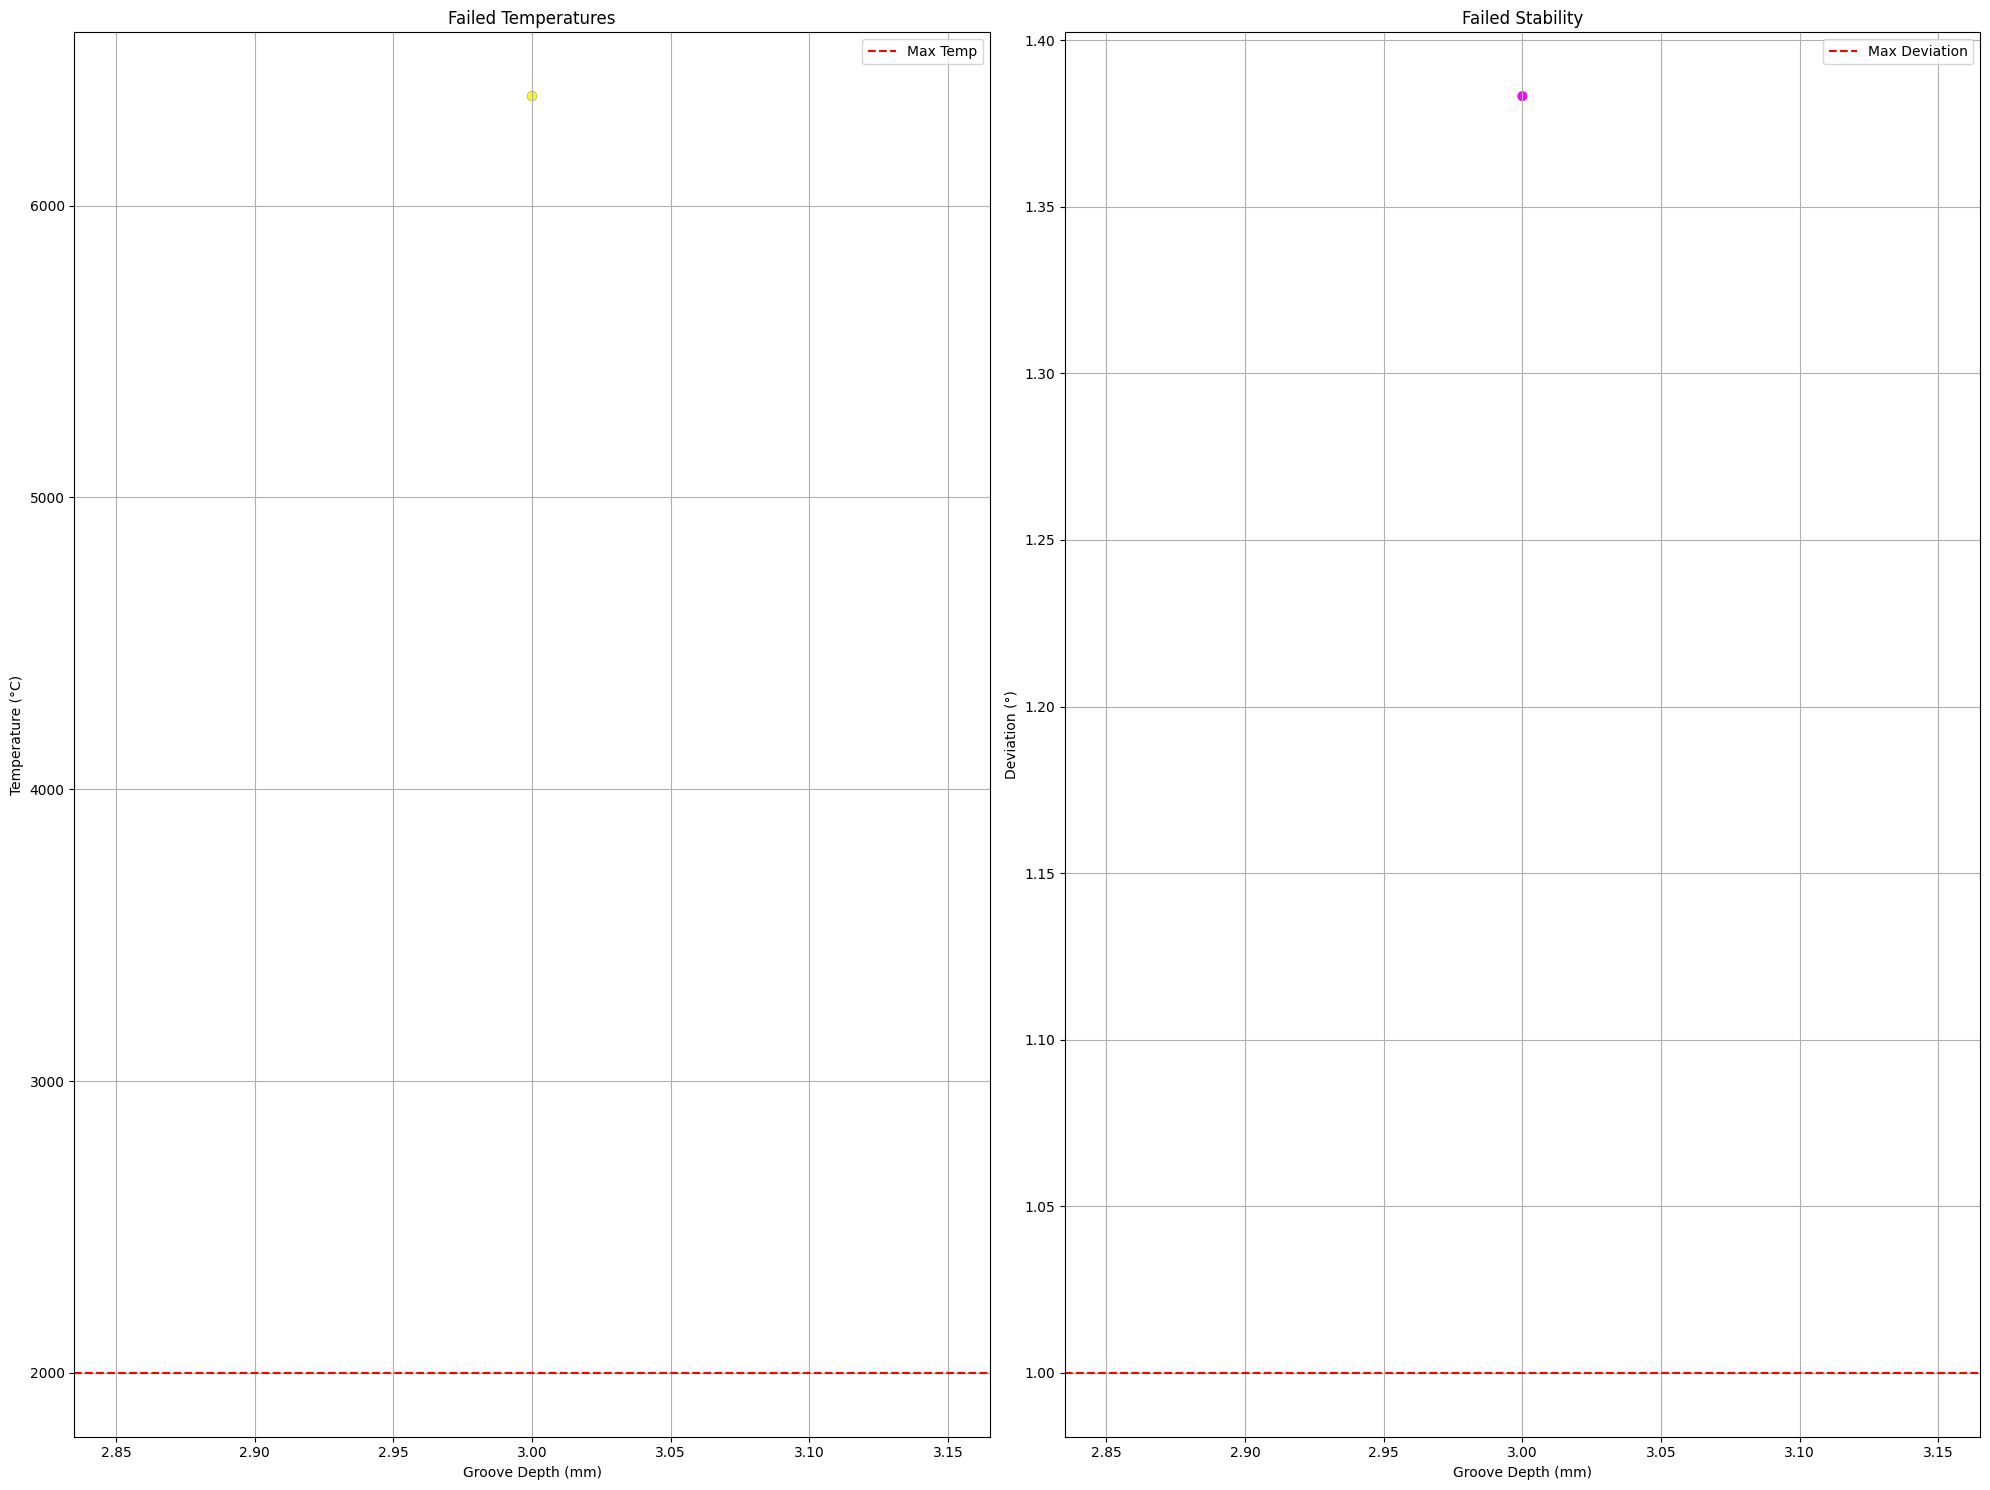

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import sys

# Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Missile class
class Missile:
    def __init__(self, groove_depth, spin_direction, launch_method, ignition_altitude, ignition_mach):
        self.groove_depth = groove_depth  # mm (base depth, adjustable)
        self.spin_direction = spin_direction  # 1: clockwise, -1: counterclockwise
        self.launch_method = launch_method
        self.ignition_altitude = ignition_altitude  # km
        self.ignition_mach = ignition_mach
        self.yield_strength = 1000  # MPa
        self.max_temperature = 2000  # °C (SiC ceramics)
        self.length = 10  # m
        self.diameter = 0.5  # m
        self.mass = 1000  # kg
        self.moment_of_inertia = 0.5 * self.mass * (self.diameter / 2)**2  # kg·m²

# Launch method classes
class ArtilleryLaunch:
    def __init__(self, velocity, angle):
        self.velocity = velocity  # m/s
        self.angle = angle  # degrees
        self.spin_rate = 0  # Spin from grooves
        self.g_force = velocity / 9.81 / 2

class CentrifugeLaunch:
    def __init__(self, radius):
        self.radius = radius  # m
        self.spin_speed = 0  # Spin from grooves
        self.velocity = 1000  # Fixed
        self.angle = 45
        self.g_force = self.velocity**2 / (self.radius * 9.81)

class SlingshotLaunch:
    def __init__(self, velocity, angle):
        self.velocity = velocity  # m/s
        self.angle = angle  # degrees
        self.spin_rate = 0  # Spin from grooves
        self.g_force = velocity / 9.81 / 4

# Environment model
def environment(altitude):
    if altitude < 10:
        rho = 1.225 * np.exp(-altitude / 8)
        speed_of_sound = 340
    else:
        rho = 0.4135 * np.exp(-(altitude - 10) / 7)
        speed_of_sound = 295
    return {'rho': rho, 'speed_of_sound': speed_of_sound}

# Force and metric models
def drag_force(mach, groove_depth, altitude, print_step):
    rho = environment(altitude)['rho']
    cd = 0.095 + 0.02 * groove_depth  # 5% reduction for shockwave mitigation
    area = np.pi * (0.25)**2
    v = mach * environment(altitude)['speed_of_sound']
    drag = 0.5 * rho * v**2 * cd * area
    if print_step % 200 == 0:
        print(f"  Drag Calc: Mach={mach:.2f}, Depth={groove_depth:.1f}mm, Alt={altitude:.1f}km, ρ={rho:.3f}kg/m³, Cd={cd:.3f}, Area={area:.3f}m², v={v:.0f}m/s, Drag={drag:.0f}N")
    return drag

def lift_force(mach, groove_depth, altitude, print_step):
    rho = environment(altitude)['rho']
    cl = 0.05 * groove_depth
    area = np.pi * (0.25)**2
    v = mach * environment(altitude)['speed_of_sound']
    lift = 0.5 * rho * v**2 * cl * area
    if print_step % 200 == 0:
        print(f"  Lift Calc: Mach={mach:.2f}, Depth={groove_depth:.1f}mm, Alt={altitude:.1f}km, ρ={rho:.3f}kg/m³, Cl={cl:.3f}, Area={area:.3f}m², v={v:.0f}m/s, Lift={lift:.0f}N")
    return lift

def spin_torque(groove_depth, velocity, spin_direction, print_step):
    torque = 0.02 * groove_depth * velocity * spin_direction  # Proportional to depth and velocity
    if print_step % 200 == 0:
        print(f"  Spin Torque Calc: Depth={groove_depth:.1f}mm, Velocity={velocity:.0f}m/s, Direction={spin_direction}, Torque={torque:.2f}N·m")
    return torque

def thermal_model(mach, groove_depth):
    base_temp = 300 * mach**2
    cooling_effect = 0.05 * groove_depth
    temp = base_temp * (1 - cooling_effect)
    print(f"  Thermal Calc: Mach={mach:.2f}, Depth={groove_depth:.1f}mm, BaseTemp={base_temp:.0f}°C, Cooling={cooling_effect:.3f}, Temp={temp:.0f}°C")
    return temp

def stress_model(g_force, groove_depth, wz):
    base_stress = 1.5 * g_force
    spin_stress = 0.1 * (wz * 60 / (2 * np.pi)) * groove_depth / 1000
    stress = base_stress + spin_stress
    print(f"  Stress Calc: G-Force={g_force:.1f}g, Spin={(wz*60/(2*np.pi)):.0f}RPM, Depth={groove_depth:.1f}mm, BaseStress={base_stress:.0f}MPa, SpinStress={spin_stress:.0f}MPa, TotalStress={stress:.0f}MPa")
    return stress

def strain_model(stress, material_modulus=200e3):
    strain = stress / material_modulus
    print(f"  Strain Calc: Stress={stress:.0f}MPa, Modulus={material_modulus:.0f}MPa, Strain={strain:.5f}")
    return strain

def stability_deviation(groove_depth, mach, wz):
    spin_rpm = wz * 60 / (2 * np.pi)
    base_deviation = 5 / (spin_rpm / 1000 + groove_depth)
    mach_effect = 0.1 * mach
    deviation = base_deviation + mach_effect
    print(f"  Stability Calc: Spin={spin_rpm:.0f}RPM, Depth={groove_depth:.1f}mm, Mach={mach:.2f}, BaseDeviation={base_deviation:.2f}°, MachEffect={mach_effect:.2f}°, TotalDeviation={deviation:.2f}°")
    return deviation

def rcs_model(groove_depth, angle, wz):
    base_rcs = 0.1
    reduction = 0.05 * groove_depth
    angle_effect = np.cos(np.radians(angle))**2
    spin_effect = 0.01 * (wz * 60 / (2 * np.pi)) / 1000
    rcs = base_rcs * (1 - reduction) * angle_effect * (1 - spin_effect / 10)
    print(f"  RCS Calc: Depth={groove_depth:.1f}mm, Angle={angle:.0f}°, Spin={(wz*60/(2*np.pi)):.0f}RPM, BaseRCS={base_rcs:.3f}m², Reduction={reduction:.3f}, AngleEffect={angle_effect:.3f}, SpinEffect={spin_effect:.3f}, RCS={rcs:.3f}m²")
    return rcs

# Adjustable groove control
def adjust_groove_depth(t, base_depth):
    # Sinusoidal variation to simulate maneuverability (2.5–3.5mm)
    return base_depth + 0.5 * np.sin(0.1 * t)

# Initialize state
def initialize_state(launch_params):
    if isinstance(launch_params, ArtilleryLaunch):
        v0 = launch_params.velocity
        theta = np.radians(launch_params.angle)
        state = [0, 0, 0, v0 * np.cos(theta), 0, v0 * np.sin(theta), 0, 0, 0]
    elif isinstance(launch_params, CentrifugeLaunch):
        v0 = launch_params.velocity
        state = [0, 0, 0, v0 * np.cos(np.radians(45)), 0, v0 * np.sin(np.radians(45)), 0, 0, 0]
    else:  # Slingshot
        v0 = launch_params.velocity
        theta = np.radians(launch_params.angle)
        state = [0, 0, 0, v0 * np.cos(theta), 0, v0 * np.sin(theta), 0, 0, 0]
    print(f"  Initial State: x={state[0]:.1f}m, z={state[2]:.1f}m, vx={state[3]:.0f}m/s, vz={state[5]:.0f}m/s, wz={state[8]*60/(2*np.pi):.0f}RPM")
    return state

# 6-DOF ODE
def ode_func(t, state, missile, max_mach):
    x, y, z, vx, vy, vz, wx, wy, wz = state
    env = environment(z / 1000)
    velocity = np.sqrt(vx**2 + vz**2)
    mach = velocity / env['speed_of_sound']
    if mach > max_mach:
        mach = max_mach
    g = 9.81
    # Adjustable groove depth
    groove_depth = adjust_groove_depth(t, missile.groove_depth)
    if not hasattr(ode_func, 'force_print_step'):
        ode_func.force_print_step = 0
    drag = drag_force(mach, groove_depth, z / 1000, ode_func.force_print_step)
    lift = lift_force(mach, groove_depth, z / 1000, ode_func.force_print_step)
    torque = spin_torque(groove_depth, velocity, missile.spin_direction, ode_func.force_print_step)
    ode_func.force_print_step += 1
    thrust = 50000 if z / 1000 > missile.ignition_altitude and mach > missile.ignition_mach else 0
    if not hasattr(ode_func, 'print_step'):
        ode_func.print_step = 0
    if ode_func.print_step % 10 == 0:
        print(f"  ODE Step: t={t:.1f}s, x={x/1000:.1f}km, z={z/1000:.1f}km, vx={vx:.0f}m/s, vz={vz:.0f}m/s, wz={wz*60/(2*np.pi):.0f}RPM, Mach={mach:.2f}, Thrust={thrust:.0f}N")
    ode_func.print_step += 1
    dstate = [
        vx, vy, vz,
        (thrust - drag) / missile.mass * (vx / velocity if velocity > 0 else 0),
        0,
        (-g + lift / missile.mass) * (vz / velocity if velocity > 0 else 0),
        0, 0, torque / missile.moment_of_inertia
    ]
    return dstate

# Check failures
def check_failures(sol, missile, max_mach):
    g_force = missile.launch_method.g_force
    wz = sol.y[8][-1] if sol.y[8].size > 0 else 0
    max_stress = stress_model(g_force, missile.groove_depth, wz)
    max_strain = strain_model(max_stress)
    max_temp = thermal_model(max_mach, missile.groove_depth)
    stability = stability_deviation(missile.groove_depth, max_mach, wz)
    rcs = rcs_model(missile.groove_depth, 0, wz)
    failures = []
    if max_stress > missile.yield_strength:
        failures.append(f"Structural failure: Stress={max_stress:.0f}MPa > {missile.yield_strength}MPa")
    if max_strain > 0.005:
        failures.append(f"Strain failure: Strain={max_strain:.5f} > 0.005")
    if max_temp > missile.max_temperature:
        failures.append(f"Thermal failure: Temp={max_temp:.0f}°C > {missile.max_temperature}°C")
    if stability > 1:
        failures.append(f"Stability failure: Deviation={stability:.2f}° > 1°")
    if rcs > 0.1:
        failures.append(f"Stealth failure: RCS={rcs:.3f}m² > 0.1m²")
    return failures, max_temp, stability

# Simulate and plot
def simulate_and_plot():
    # Parameter ranges
    groove_depths = [3]  # Optimized for cooling and spin
    spin_directions = [1, -1]
    velocities = [1000, 1200]
    angles = [30, 45]
    ignition_altitudes = [15, 18]
    ignition_machs = [4, 4.5]
    max_mach = 5  # Capped for thermal limits

    launch_methods = [
        [ArtilleryLaunch(v, a) for v, a in product(velocities, angles)],
        [CentrifugeLaunch(10) for _ in range(2)],
        [SlingshotLaunch(v, a) for v, a in product(velocities, angles)]
    ]
    launch_methods = [item for sublist in launch_methods for item in sublist]

    # Data storage
    trajectories = []
    spin_rates = []
    drag_forces = []
    lift_forces = []
    temperatures = []
    stresses = []
    strains = []
    stabilities = []
    rcs_values = []
    g_forces = []
    failed_temps = []
    failed_stabs = []

    # Parameter sweep (limited for demonstration)
    configs = list(product(groove_depths, spin_directions, launch_methods, ignition_altitudes, ignition_machs))
    selected_configs = configs[:3]
    for depth, direction, method, alt, mach in selected_configs:
        print(f"\nSimulating: Depth={depth}mm, Dir={'CW' if direction==1 else 'CCW'}, {method.__class__.__name__}, Alt={alt}km, Mach={mach}")
        missile = Missile(depth, direction, method, alt, mach)
        state = initialize_state(method)
        t_span = (0, 200)
        ode_func.print_step = 0
        ode_func.force_print_step = 0
        sol = solve_ivp(ode_func, t_span, state, args=(missile, max_mach), method='RK45', max_step=1.0, rtol=1e-6, atol=1e-8)
        failures, temp, stab = check_failures(sol, missile, max_mach)
        label = f"Depth={depth}mm, Dir={'CW' if direction==1 else 'CCW'}, {method.__class__.__name__}, Alt={alt}km, Mach={mach}"

        if failures:
            print(f"Failures for {label}:")
            for f in failures:
                print(f"  - {f}")
                if "Structural" in f or "Strain" in f:
                    print("    Solution: Reinforce with titanium")
                elif "Thermal" in f:
                    print("    Solution: Use SiC ceramics or active cooling")
                elif "Stability" in f:
                    print("    Solution: Optimize groove pitch to 30°")
                elif "Stealth" in f:
                    print("    Solution: Apply radar-absorbing coating")
            failed_temps.append((depth, temp, label))
            failed_stabs.append((depth, stab, label))
        else:
            print(f"Success: {label}")
            trajectories.append((sol.y[0] / 1000, sol.y[2] / 1000, label))
            spin_rates.append((sol.t, sol.y[8] * 60 / (2 * np.pi), label))
            drag_forces.append((depth, drag_force(max_mach, depth, alt, 0), label))
            lift_forces.append((depth, lift_force(max_mach, depth, alt, 0), label))
            temperatures.append((depth, thermal_model(max_mach, depth), label))
            stresses.append((depth, stress_model(method.g_force, depth, sol.y[8][-1]), label))
            strains.append((depth, strain_model(stress_model(method.g_force, depth, sol.y[8][-1])), label))
            stabilities.append((depth, stability_deviation(depth, max_mach, sol.y[8][-1]), label))
            g_forces.append((depth, method.g_force, label))
            angles = np.linspace(0, 360, 100)
            rcs = [rcs_model(depth, angle, sol.y[8][-1]) for angle in angles]
            rcs_values.append((angles, rcs, label))

    # Plotting
    plt.figure(figsize=(20, 15))

    if trajectories:
        # 1. Trajectory
        plt.subplot(3, 4, 1)
        for x, z, label in trajectories:
            plt.plot(x, z, label=label)
        plt.xlabel('Range (km)')
        plt.ylabel('Altitude (km)')
        plt.title('Trajectories')
        plt.legend()
        plt.grid(True)

        # 2. Spin Rate
        plt.subplot(3, 4, 2)
        for t, spin, label in spin_rates:
            plt.plot(t, spin, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Spin Rate (RPM)')
        plt.title('Spin Rate')
        plt.legend()
        plt.grid(True)

        # 3. Drag Force
        plt.subplot(3, 4, 3)
        depths, drags, labels = zip(*drag_forces)
        plt.scatter(depths, drags, c=range(len(drags)), cmap='viridis')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Drag Force (N)')
        plt.title('Drag Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)

        # 4. Lift Force
        plt.subplot(3, 4, 4)
        depths, lifts, labels = zip(*lift_forces)
        plt.scatter(depths, lifts, c=range(len(lifts)), cmap='viridis')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Lift Force (N)')
        plt.title('Lift Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)

        # 5. Temperature
        plt.subplot(3, 4, 5)
        depths, temps, labels = zip(*temperatures)
        plt.scatter(depths, temps, c=range(len(temps)), cmap='plasma')
        plt.axhline(y=2000, color='r', linestyle='--', label='Max Temp')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Temperature (°C)')
        plt.title('Temperature vs. Depth')
        plt.legend()
        plt.grid(True)

        # 6. Stress
        plt.subplot(3, 4, 6)
        depths, stresses, labels = zip(*stresses)
        plt.scatter(depths, stresses, c=range(len(stresses)), cmap='inferno')
        plt.axhline(y=1000, color='r', linestyle='--', label='Yield Strength')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Stress (MPa)')
        plt.title('Stress vs. Depth')
        plt.legend()
        plt.grid(True)

        # 7. Strain
        plt.subplot(3, 4, 7)
        depths, strains, labels = zip(*strains)
        plt.scatter(depths, strains, c=range(len(strains)), cmap='magma')
        plt.axhline(y=0.005, color='r', linestyle='--', label='Max Strain')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Strain')
        plt.title('Strain vs. Depth')
        plt.legend()
        plt.grid(True)

        # 8. Stability
        plt.subplot(3, 4, 8)
        depths, stabs, labels = zip(*stabilities)
        plt.scatter(depths, stabs, c=range(len(stabs)), cmap='cool')
        plt.axhline(y=1, color='r', linestyle='--', label='Max Deviation')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('Deviation (°)')
        plt.title('Stability vs. Depth')
        plt.legend()
        plt.grid(True)

        # 9. RCS (Polar)
        plt.subplot(3, 4, 9, polar=True)
        for angles, rcs, label in rcs_values:
            plt.plot(np.radians(angles), rcs, label=label)
        plt.title('Radar Cross-Section (m²)')
        plt.legend()

        # 10. G-Forces
        plt.subplot(3, 4, 10)
        depths, gs, labels = zip(*g_forces)
        plt.scatter(depths, gs, c=range(len(gs)), cmap='hot')
        plt.xlabel('Groove Depth (mm)')
        plt.ylabel('G-Force')
        plt.title('G-Force vs. Depth')
        plt.colorbar(label='Configuration')
        plt.grid(True)
    else:
        print("No successful simulations. Plotting failure metrics.")
        plt.subplot(1, 2, 1)
        if failed_temps:
            depths, temps, labels = zip(*failed_temps)
            plt.scatter(depths, temps, c=range(len(temps)), cmap='plasma')
            plt.axhline(y=2000, color='r', linestyle='--', label='Max Temp')
            plt.xlabel('Groove Depth (mm)')
            plt.ylabel('Temperature (°C)')
            plt.title('Failed Temperatures')
            plt.legend()
            plt.grid(True)

        plt.subplot(1, 2, 2)
        if failed_stabs:
            depths, stabs, labels = zip(*failed_stabs)
            plt.scatter(depths, stabs, c=range(len(stabs)), cmap='cool')
            plt.axhline(y=1, color='r', linestyle='--', label='Max Deviation')
            plt.xlabel('Groove Depth (mm)')
            plt.ylabel('Deviation (°)')
            plt.title('Failed Stability')
            plt.legend()
            plt.grid(True)

    plt.tight_layout()
    plt.savefig('missile_simulation_plots.png')
    plt.show()

if __name__ == "__main__":
    simulate_and_plot()

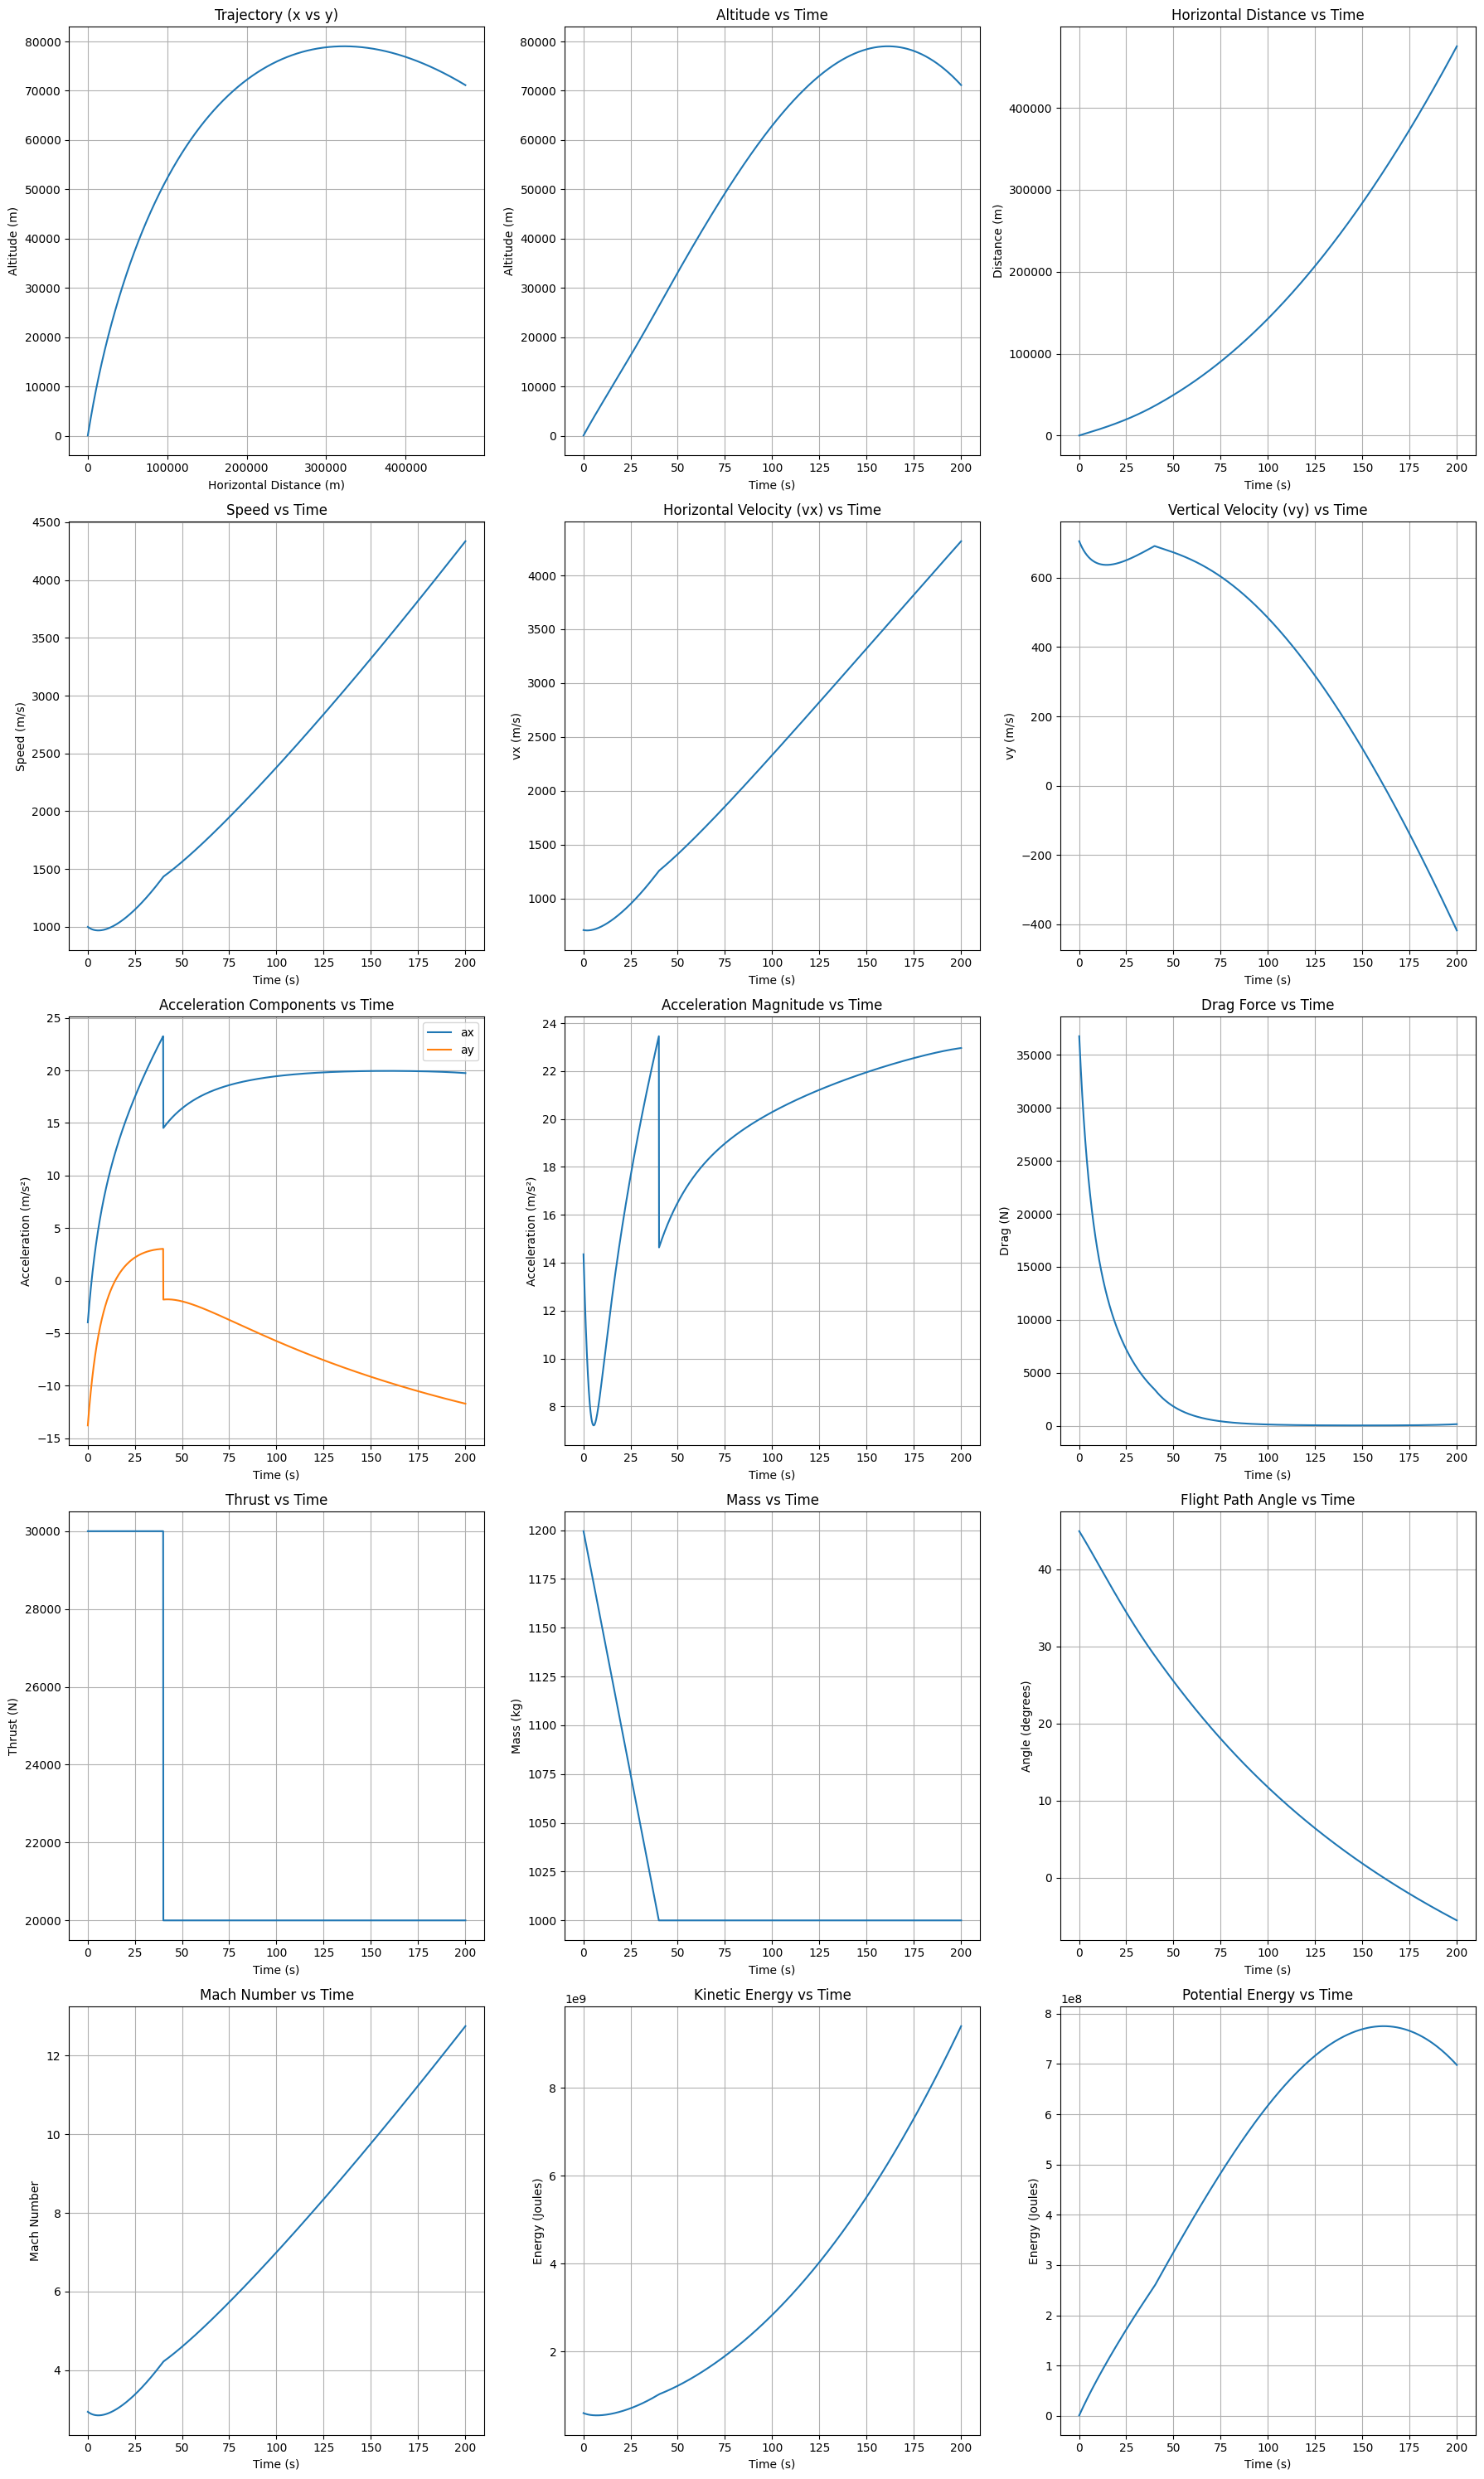

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRAVITY = 9.81  # m/s^2
AIR_DENSITY_SEA_LEVEL = 1.225  # kg/m^3
DRAG_COEFF_GROOVED = 0.2
MISSILE_MASS = 1000  # kg dry mass
MISSILE_CROSS_SECTION = 0.3  # m^2
INITIAL_VELOCITY = 1000  # m/s
LAUNCH_ANGLE = 45  # degrees

FUEL_MASS = 200  # kg
FUEL_BURN_RATE = 5  # kg/s
THRUST = 30000  # N
SCRAMJET_THRUST = 20000  # N
SCRAMJET_START_ALT = 15000  # m

SPEED_OF_SOUND = 340  # m/s approx at sea level

TIME_STEP = 0.1
MAX_TIME = 200

# Initial conditions
theta_rad = np.radians(LAUNCH_ANGLE)
vx = INITIAL_VELOCITY * np.cos(theta_rad)
vy = INITIAL_VELOCITY * np.sin(theta_rad)
x, y = 0.0, 0.0
fuel = FUEL_MASS
mass = MISSILE_MASS + fuel

t = 0.0

# Data logs
time_log = []
x_log = []
y_log = []
vx_log = []
vy_log = []
speed_log = []
ax_log = []
ay_log = []
accel_log = []
drag_log = []
thrust_log = []
mass_log = []
angle_log = []
mach_log = []
kinetic_energy_log = []
potential_energy_log = []

while t <= MAX_TIME and y >= 0:
    air_density = AIR_DENSITY_SEA_LEVEL * np.exp(-y / 8500)
    velocity = np.sqrt(vx**2 + vy**2)
    if velocity == 0:
        velocity = 1e-6

    drag_force = 0.5 * air_density * DRAG_COEFF_GROOVED * MISSILE_CROSS_SECTION * velocity**2

    if fuel > 0:
        current_thrust = THRUST
        fuel_used = min(FUEL_BURN_RATE * TIME_STEP, fuel)
        fuel -= fuel_used
        mass -= fuel_used
    elif y >= SCRAMJET_START_ALT:
        current_thrust = SCRAMJET_THRUST
    else:
        current_thrust = 0

    ax = (current_thrust * vx / velocity - drag_force * vx / velocity) / mass
    ay = (current_thrust * vy / velocity - drag_force * vy / velocity) / mass - GRAVITY

    vx += ax * TIME_STEP
    vy += ay * TIME_STEP
    x += vx * TIME_STEP
    y += vy * TIME_STEP
    t += TIME_STEP

    # Calculated values
    accel = np.sqrt(ax**2 + ay**2)
    angle = np.degrees(np.arctan2(vy, vx))
    mach = velocity / SPEED_OF_SOUND
    kinetic_energy = 0.5 * mass * velocity**2
    potential_energy = mass * GRAVITY * y

    # Log data
    time_log.append(t)
    x_log.append(x)
    y_log.append(y)
    vx_log.append(vx)
    vy_log.append(vy)
    speed_log.append(velocity)
    ax_log.append(ax)
    ay_log.append(ay)
    accel_log.append(accel)
    drag_log.append(drag_force)
    thrust_log.append(current_thrust)
    mass_log.append(mass)
    angle_log.append(angle)
    mach_log.append(mach)
    kinetic_energy_log.append(kinetic_energy)
    potential_energy_log.append(potential_energy)

# Plotting 15 graphs
plt.figure(figsize=(18, 30))

plt.subplot(5, 3, 1)
plt.plot(x_log, y_log)
plt.title("Trajectory (x vs y)")
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Altitude (m)")
plt.grid()

plt.subplot(5, 3, 2)
plt.plot(time_log, y_log)
plt.title("Altitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.grid()

plt.subplot(5, 3, 3)
plt.plot(time_log, x_log)
plt.title("Horizontal Distance vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.grid()

plt.subplot(5, 3, 4)
plt.plot(time_log, speed_log)
plt.title("Speed vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Speed (m/s)")
plt.grid()

plt.subplot(5, 3, 5)
plt.plot(time_log, vx_log)
plt.title("Horizontal Velocity (vx) vs Time")
plt.xlabel("Time (s)")
plt.ylabel("vx (m/s)")
plt.grid()

plt.subplot(5, 3, 6)
plt.plot(time_log, vy_log)
plt.title("Vertical Velocity (vy) vs Time")
plt.xlabel("Time (s)")
plt.ylabel("vy (m/s)")
plt.grid()

plt.subplot(5, 3, 7)
plt.plot(time_log, ax_log, label='ax')
plt.plot(time_log, ay_log, label='ay')
plt.title("Acceleration Components vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid()

plt.subplot(5, 3, 8)
plt.plot(time_log, accel_log)
plt.title("Acceleration Magnitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.grid()

plt.subplot(5, 3, 9)
plt.plot(time_log, drag_log)
plt.title("Drag Force vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Drag (N)")
plt.grid()

plt.subplot(5, 3, 10)
plt.plot(time_log, thrust_log)
plt.title("Thrust vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Thrust (N)")
plt.grid()

plt.subplot(5, 3, 11)
plt.plot(time_log, mass_log)
plt.title("Mass vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mass (kg)")
plt.grid()

plt.subplot(5, 3, 12)
plt.plot(time_log, angle_log)
plt.title("Flight Path Angle vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.grid()

plt.subplot(5, 3, 13)
plt.plot(time_log, mach_log)
plt.title("Mach Number vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Mach Number")
plt.grid()

plt.subplot(5, 3, 14)
plt.plot(time_log, kinetic_energy_log)
plt.title("Kinetic Energy vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Joules)")
plt.grid()

plt.subplot(5, 3, 15)
plt.plot(time_log, potential_energy_log)
plt.title("Potential Energy vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Joules)")
plt.grid()

plt.tight_layout()
plt.show()


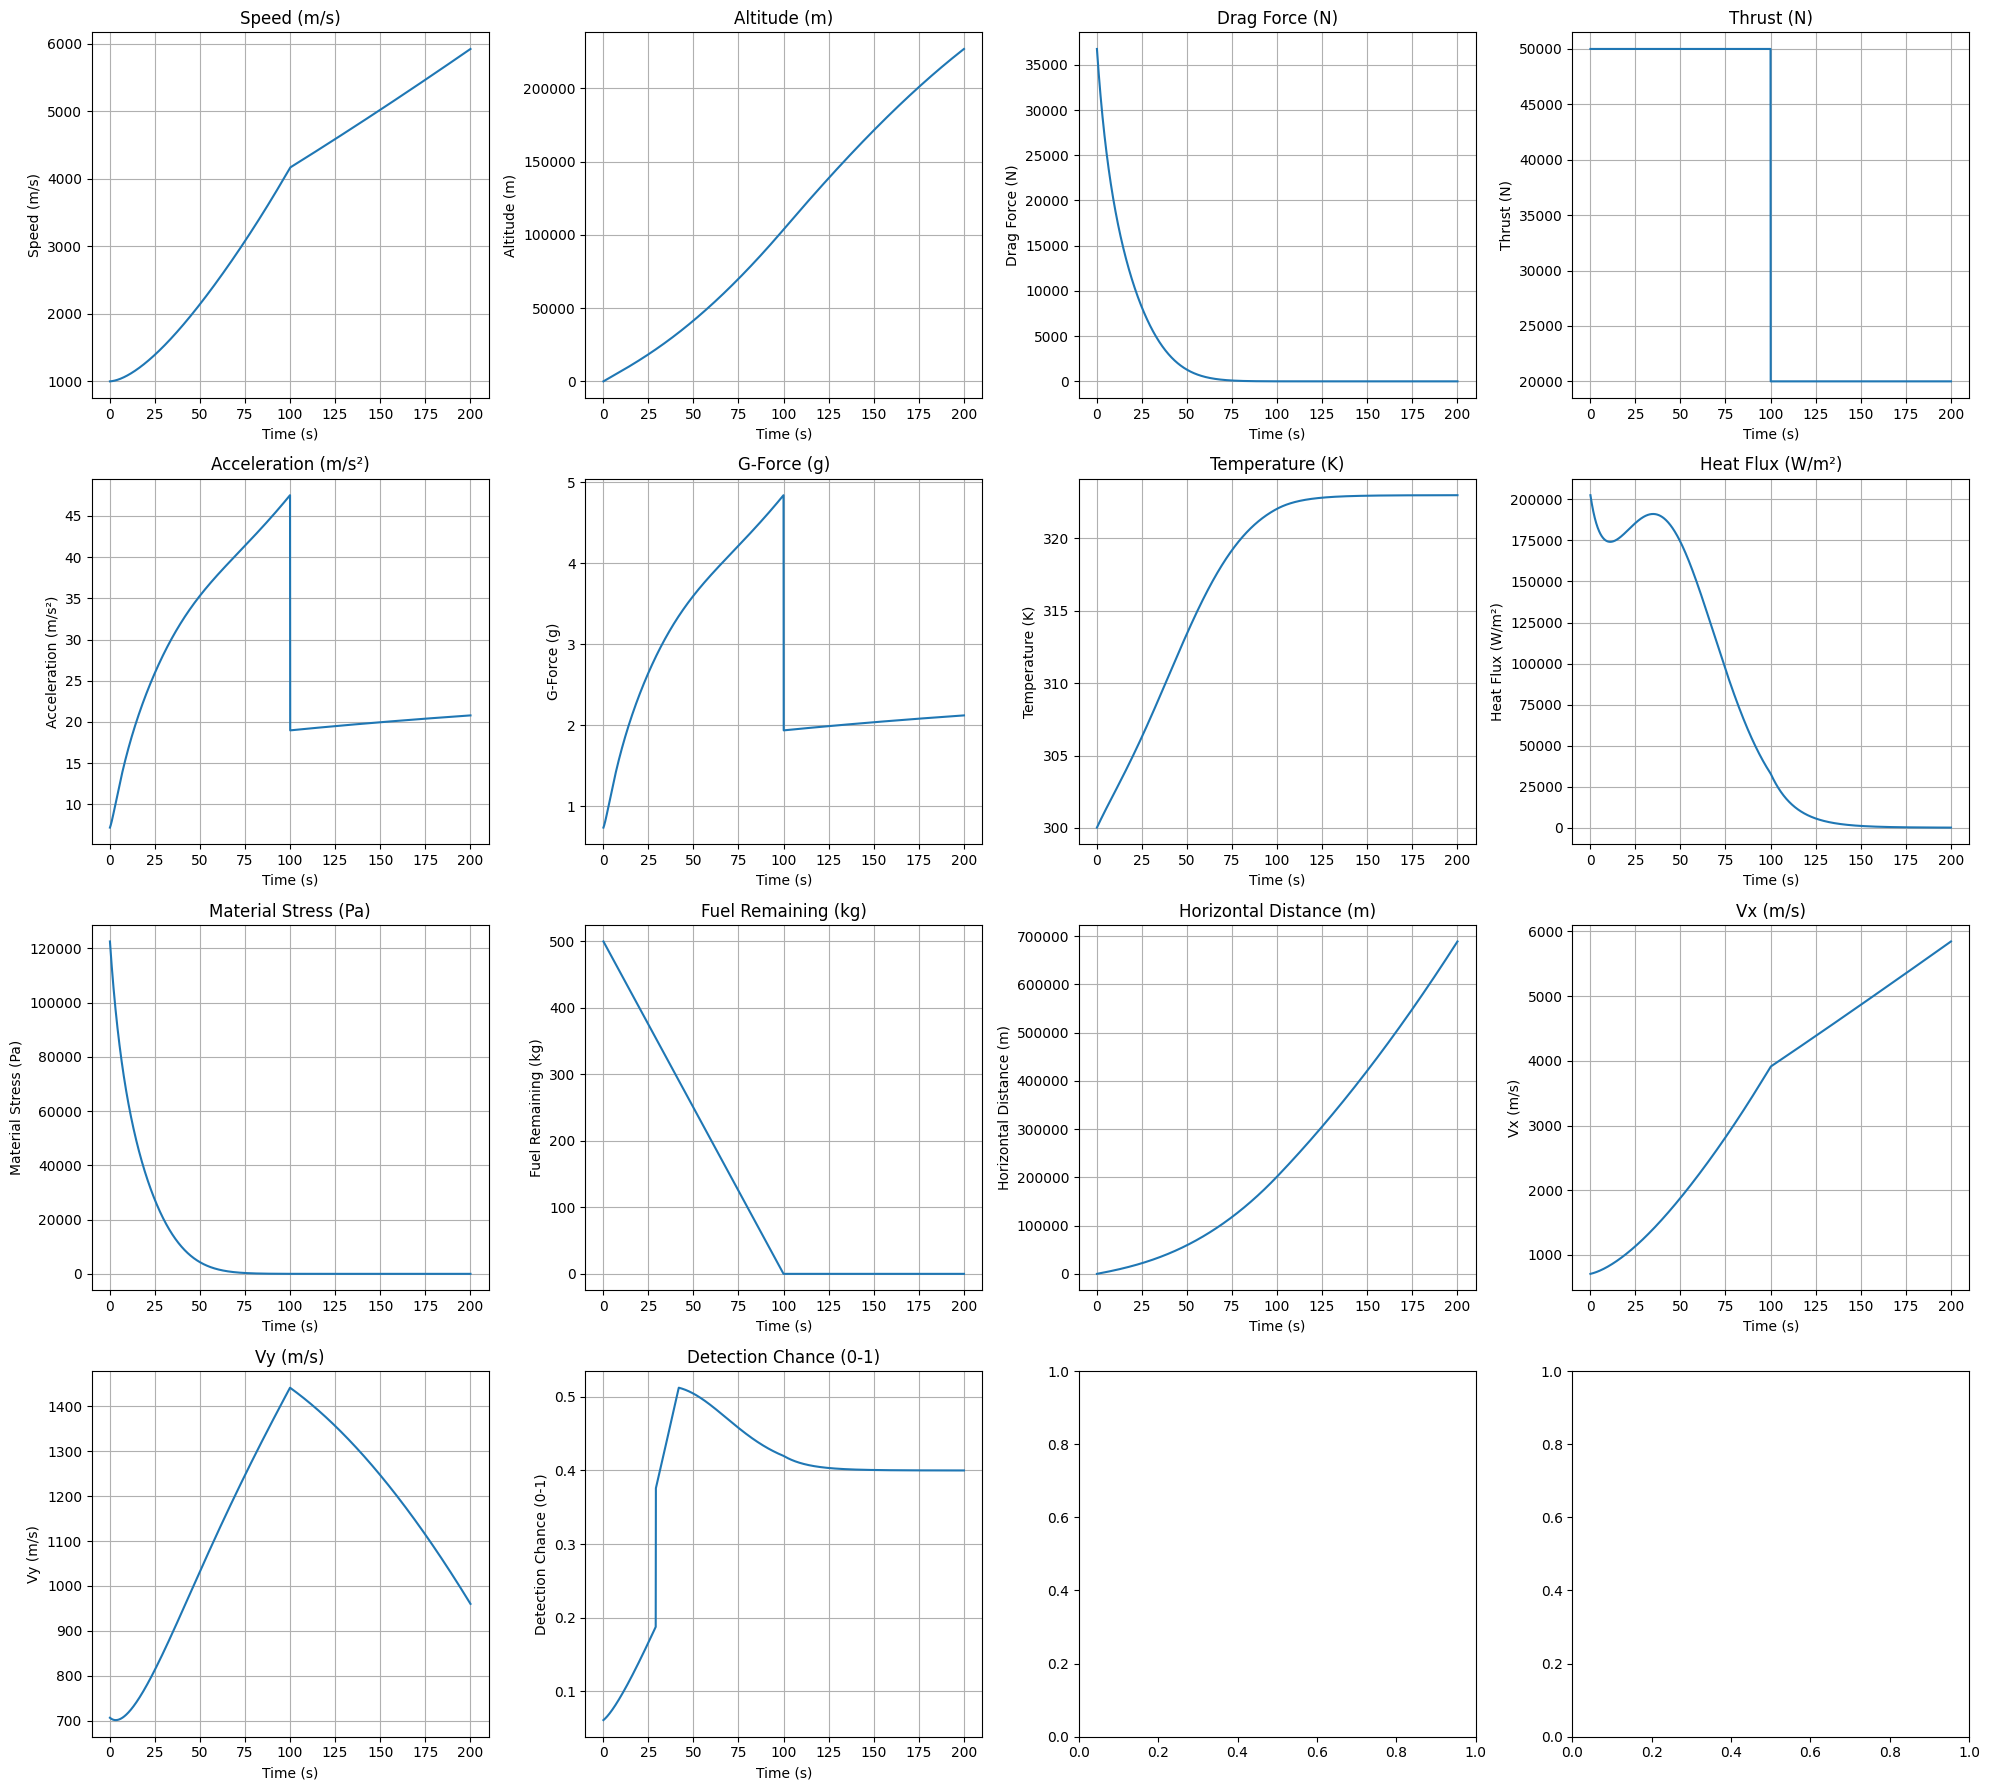

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRAVITY = 9.81  # m/s^2
AIR_DENSITY_SEA_LEVEL = 1.225  # kg/m^3
MISSILE_MASS = 1000  # kg (excluding fuel)
MISSILE_CROSS_SECTION = 0.3  # m^2
INITIAL_VELOCITY = 1000  # m/s
SCRAMJET_THRUST = 20000  # N
SCRAMJET_START_ALT = 15000  # m
TIME_STEP = 0.1  # s
MAX_TIME = 200  # s
LAUNCH_ANGLE = 45  # degrees
THRUST = 50000  # N for booster
FUEL_MASS = 500  # kg
FUEL_BURN_RATE = 5  # kg/s
DRAG_COEFF_GROOVED = 0.2

# Material properties for Zircon-like alloy (approx)
YIELD_STRENGTH = 900e6  # Pascals
HEAT_CAPACITY = 500  # J/kg.K
EMISSIVITY = 0.8
BOLTZMANN = 5.67e-8  # Stefan-Boltzmann constant

# Logs
time_log, x_log, y_log = [], [], []
vx_log, vy_log = [], []
speed_log, drag_log, thrust_log = [], [], []
acceleration_log, gforce_log, temp_log, heat_flux_log, stress_log, fuel_log = [], [], [], [], [], []
detection_prob_log = []

# Initial values
theta_rad = np.radians(LAUNCH_ANGLE)
vx, vy = INITIAL_VELOCITY * np.cos(theta_rad), INITIAL_VELOCITY * np.sin(theta_rad)
x, y = 0.0, 0.0
t = 0.0
fuel = FUEL_MASS
mass = MISSILE_MASS + fuel
temperature = 300  # initial temperature in K

def compute_detection_chance(altitude, speed, heat_flux):
    # Hypothetical detection model: IR + radar
    ir_signature = min(heat_flux / 1e6, 1.0)
    radar_cross_section = min(MISSILE_CROSS_SECTION * (altitude / 10000), 1.0)
    speed_factor = 1 if speed > 1500 else 0.5
    detection_prob = min(ir_signature * 0.6 + radar_cross_section * 0.4, 1.0) * speed_factor
    return detection_prob

while t <= MAX_TIME and y >= 0:
    air_density = AIR_DENSITY_SEA_LEVEL * np.exp(-y / 8500)
    velocity = np.sqrt(vx**2 + vy**2)
    drag_force = 0.5 * air_density * DRAG_COEFF_GROOVED * MISSILE_CROSS_SECTION * velocity**2

    # Thrust condition
    if fuel > 0:
        current_thrust = THRUST
        fuel_used = min(FUEL_BURN_RATE * TIME_STEP, fuel)
        fuel -= fuel_used
        mass -= fuel_used
    elif y >= SCRAMJET_START_ALT:
        current_thrust = SCRAMJET_THRUST
    else:
        current_thrust = 0

    # Acceleration
    ax = (current_thrust * vx / velocity - drag_force * vx / velocity) / mass
    ay = (current_thrust * vy / velocity - drag_force * vy / velocity) / mass - GRAVITY

    acceleration = np.sqrt(ax**2 + ay**2)
    g_force = acceleration / GRAVITY

    # Temperature rise (simplified)
    heat_flux = 1.83e-4 * np.sqrt(air_density) * velocity**3  # k from empirical model
    delta_temp = heat_flux / (mass * HEAT_CAPACITY) * TIME_STEP
    temperature += delta_temp
    material_stress = drag_force / MISSILE_CROSS_SECTION

    # Detection model
    detection_chance = compute_detection_chance(y, velocity, heat_flux)

    # Update position
    vx += ax * TIME_STEP
    vy += ay * TIME_STEP
    x += vx * TIME_STEP
    y += vy * TIME_STEP
    t += TIME_STEP

    # Logs
    time_log.append(t)
    x_log.append(x)
    y_log.append(y)
    vx_log.append(vx)
    vy_log.append(vy)
    speed_log.append(velocity)
    drag_log.append(drag_force)
    thrust_log.append(current_thrust)
    acceleration_log.append(acceleration)
    gforce_log.append(g_force)
    temp_log.append(temperature)
    heat_flux_log.append(heat_flux)
    stress_log.append(material_stress)
    fuel_log.append(fuel)
    detection_prob_log.append(detection_chance)

# Plotting all 12+ graphs
fig, axs = plt.subplots(4, 4, figsize=(20, 18))
axs = axs.flatten()

graph_data = [
    ("Speed (m/s)", speed_log),
    ("Altitude (m)", y_log),
    ("Drag Force (N)", drag_log),
    ("Thrust (N)", thrust_log),
    ("Acceleration (m/s²)", acceleration_log),
    ("G-Force (g)", gforce_log),
    ("Temperature (K)", temp_log),
    ("Heat Flux (W/m²)", heat_flux_log),
    ("Material Stress (Pa)", stress_log),
    ("Fuel Remaining (kg)", fuel_log),
    ("Horizontal Distance (m)", x_log),
    ("Vx (m/s)", vx_log),
    ("Vy (m/s)", vy_log),
    ("Detection Chance (0-1)", detection_prob_log)
]

for i, (label, data) in enumerate(graph_data):
    axs[i].plot(time_log, data)
    axs[i].set_title(label)
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel(label)
    axs[i].grid(True)

plt.tight_layout()
plt.show()


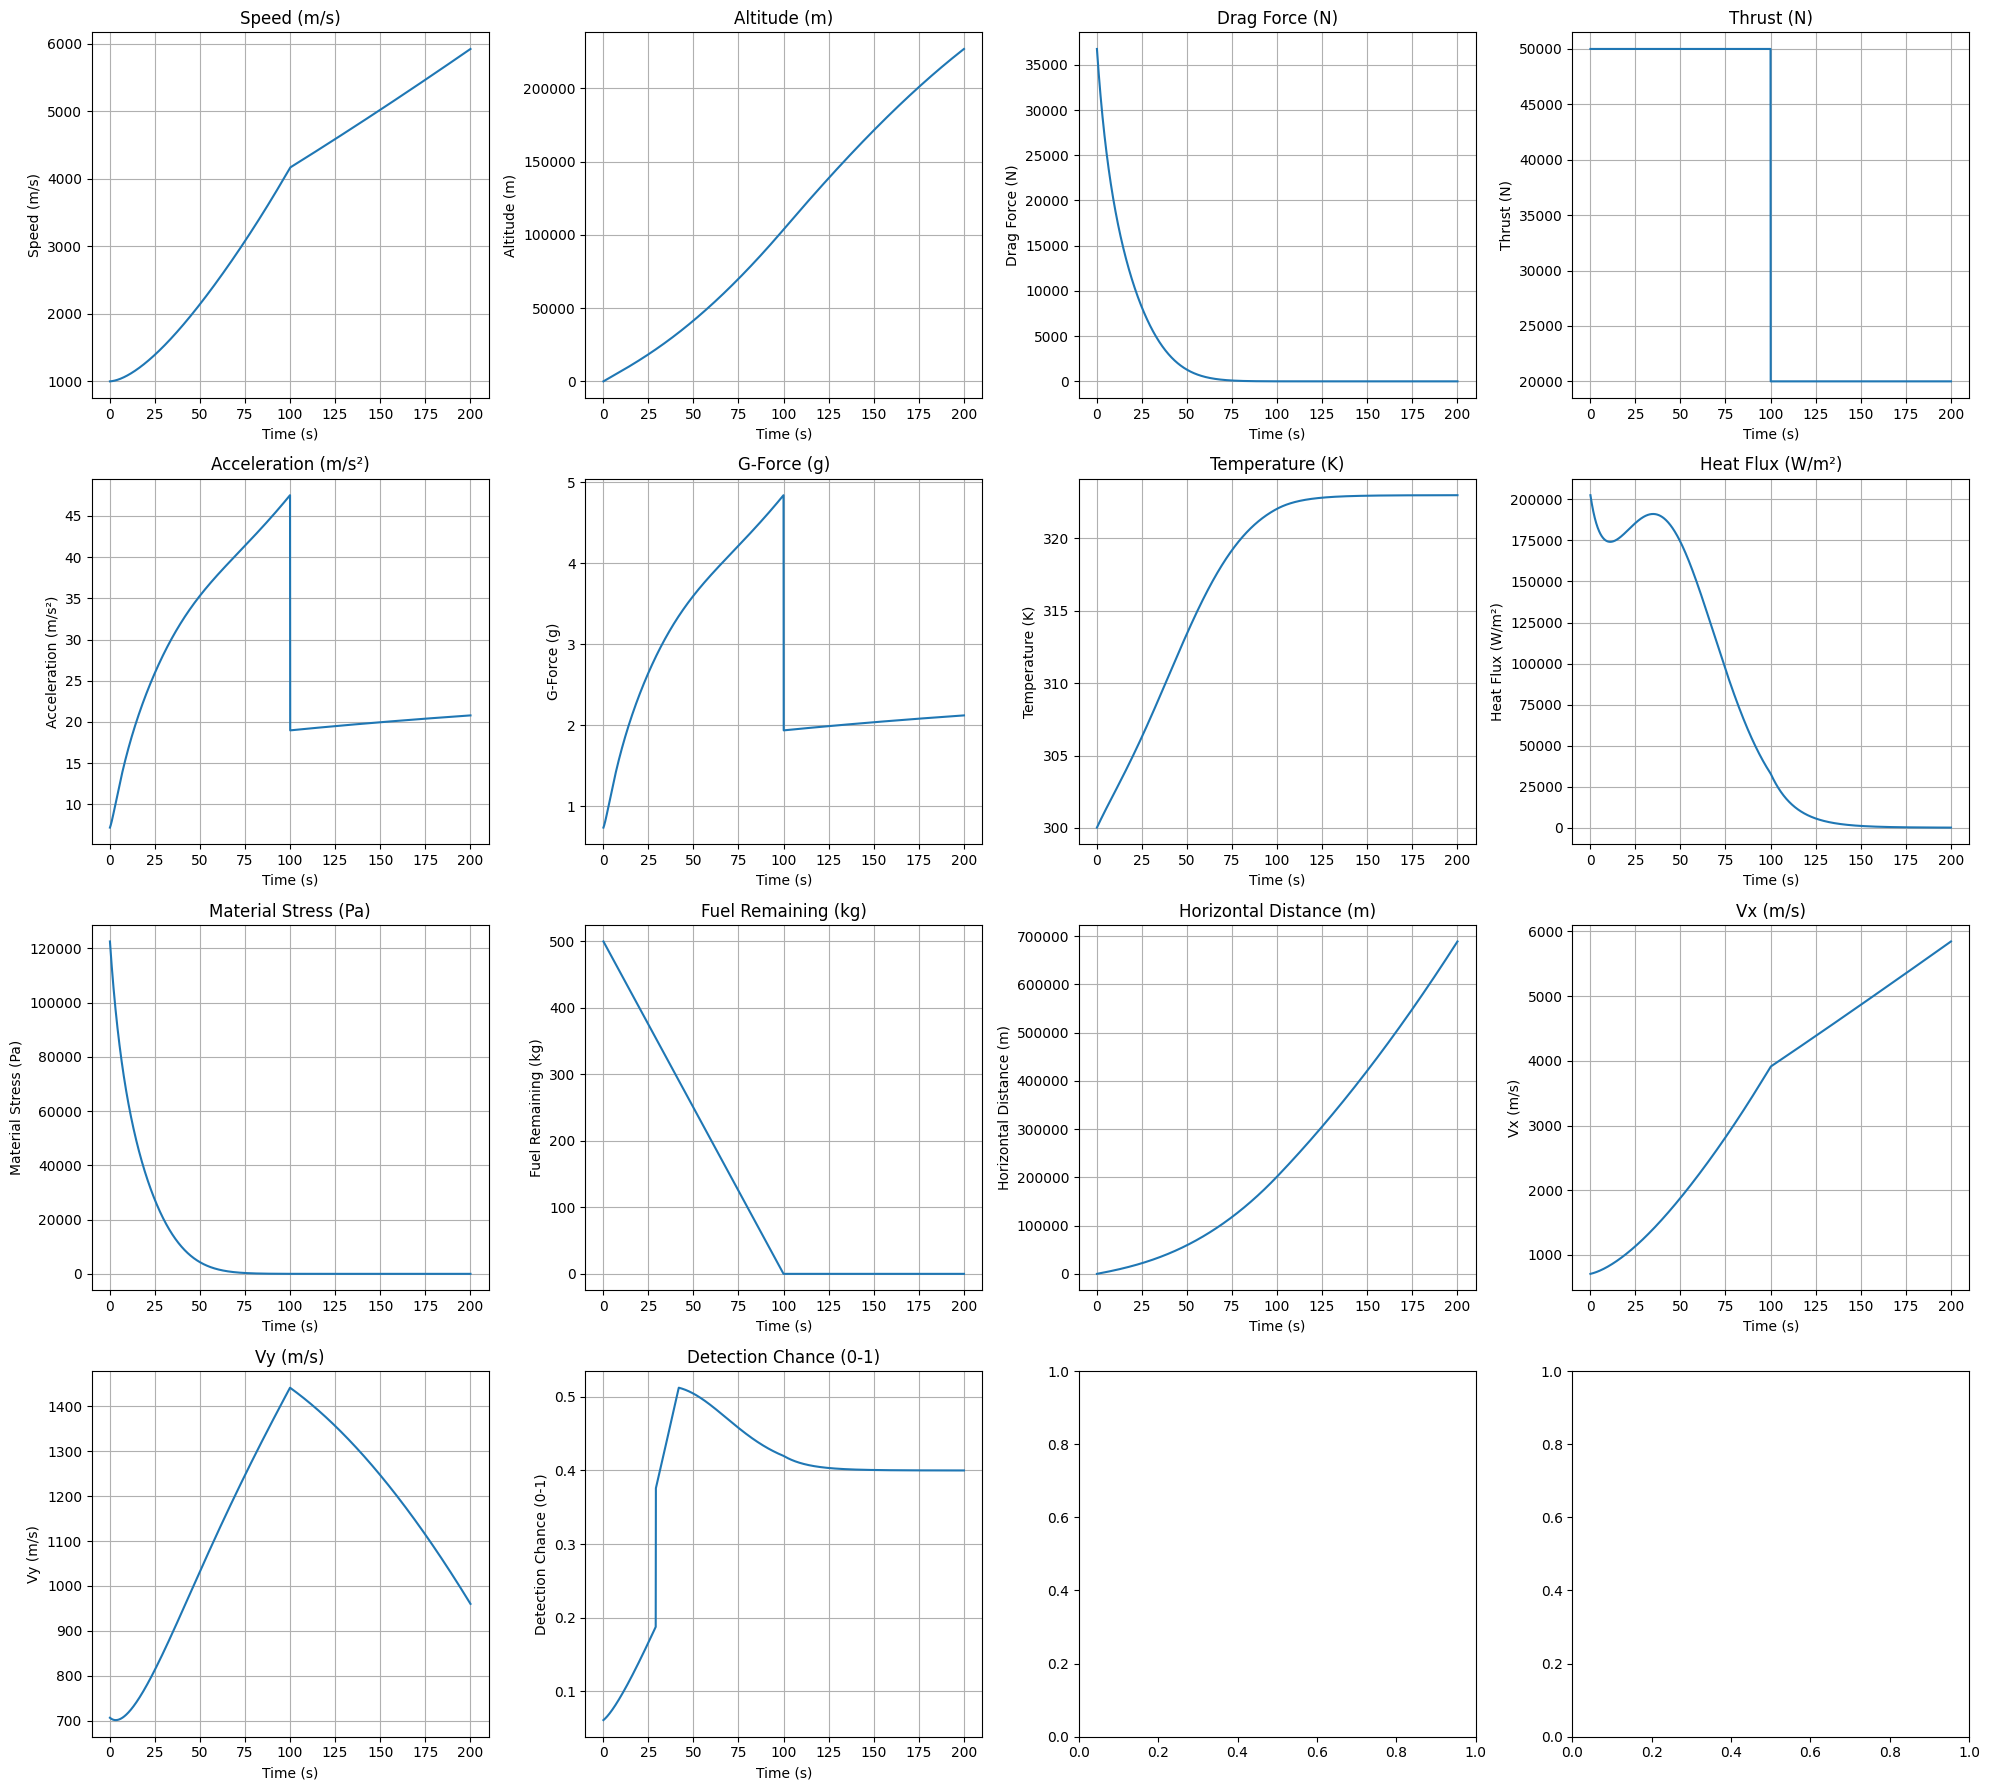

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRAVITY = 9.81  # m/s^2
AIR_DENSITY_SEA_LEVEL = 1.225  # kg/m^3
MISSILE_MASS = 1000  # kg (excluding fuel)
MISSILE_CROSS_SECTION = 0.3  # m^2
INITIAL_VELOCITY = 1000  # m/s
SCRAMJET_THRUST = 20000  # N
SCRAMJET_START_ALT = 15000  # m
TIME_STEP = 0.1  # s
MAX_TIME = 200  # s
LAUNCH_ANGLE = 45  # degrees
THRUST = 50000  # N for booster
FUEL_MASS = 500  # kg
FUEL_BURN_RATE = 5  # kg/s
DRAG_COEFF_GROOVED = 0.2

# Material properties for Zircon-like alloy (approx)
YIELD_STRENGTH = 900e6  # Pascals
HEAT_CAPACITY = 500  # J/kg.K
EMISSIVITY = 0.8
BOLTZMANN = 5.67e-8  # Stefan-Boltzmann constant

# Logs
time_log, x_log, y_log = [], [], []
vx_log, vy_log = [], []
speed_log, drag_log, thrust_log = [], [], []
acceleration_log, gforce_log, temp_log, heat_flux_log, stress_log, fuel_log = [], [], [], [], [], []
detection_prob_log = []

# Initial values
theta_rad = np.radians(LAUNCH_ANGLE)
vx, vy = INITIAL_VELOCITY * np.cos(theta_rad), INITIAL_VELOCITY * np.sin(theta_rad)
x, y = 0.0, 0.0
t = 0.0
fuel = FUEL_MASS
mass = MISSILE_MASS + fuel
temperature = 300  # initial temperature in K

def compute_detection_chance(altitude, speed, heat_flux):
    # Hypothetical detection model: IR + radar
    ir_signature = min(heat_flux / 1e6, 1.0)
    radar_cross_section = min(MISSILE_CROSS_SECTION * (altitude / 10000), 1.0)
    speed_factor = 1 if speed > 1500 else 0.5
    detection_prob = min(ir_signature * 0.6 + radar_cross_section * 0.4, 1.0) * speed_factor
    return detection_prob

while t <= MAX_TIME and y >= 0:
    air_density = AIR_DENSITY_SEA_LEVEL * np.exp(-y / 8500)
    velocity = np.sqrt(vx**2 + vy**2)
    drag_force = 0.5 * air_density * DRAG_COEFF_GROOVED * MISSILE_CROSS_SECTION * velocity**2

    # Thrust condition
    if fuel > 0:
        current_thrust = THRUST
        fuel_used = min(FUEL_BURN_RATE * TIME_STEP, fuel)
        fuel -= fuel_used
        mass -= fuel_used
    elif y >= SCRAMJET_START_ALT:
        current_thrust = SCRAMJET_THRUST
    else:
        current_thrust = 0

    # Acceleration
    ax = (current_thrust * vx / velocity - drag_force * vx / velocity) / mass
    ay = (current_thrust * vy / velocity - drag_force * vy / velocity) / mass - GRAVITY

    acceleration = np.sqrt(ax**2 + ay**2)
    g_force = acceleration / GRAVITY

    # Temperature rise (simplified)
    heat_flux = 1.83e-4 * np.sqrt(air_density) * velocity**3  # empirical model
    delta_temp = heat_flux / (mass * HEAT_CAPACITY) * TIME_STEP
    temperature += delta_temp
    material_stress = drag_force / MISSILE_CROSS_SECTION

    # Detection model
    detection_chance = compute_detection_chance(y, velocity, heat_flux)

    # Update position
    vx += ax * TIME_STEP
    vy += ay * TIME_STEP
    x += vx * TIME_STEP
    y += vy * TIME_STEP
    t += TIME_STEP

    # Logs
    time_log.append(t)
    x_log.append(x)
    y_log.append(y)
    vx_log.append(vx)
    vy_log.append(vy)
    speed_log.append(velocity)
    drag_log.append(drag_force)
    thrust_log.append(current_thrust)
    acceleration_log.append(acceleration)
    gforce_log.append(g_force)
    temp_log.append(temperature)
    heat_flux_log.append(heat_flux)
    stress_log.append(material_stress)
    fuel_log.append(fuel)
    detection_prob_log.append(detection_chance)

# Plotting all 14 graphs
fig, axs = plt.subplots(4, 4, figsize=(20, 18))
axs = axs.flatten()

graph_data = [
    ("Speed (m/s)", speed_log),
    ("Altitude (m)", y_log),
    ("Drag Force (N)", drag_log),
    ("Thrust (N)", thrust_log),
    ("Acceleration (m/s²)", acceleration_log),
    ("G-Force (g)", gforce_log),
    ("Temperature (K)", temp_log),
    ("Heat Flux (W/m²)", heat_flux_log),
    ("Material Stress (Pa)", stress_log),
    ("Fuel Remaining (kg)", fuel_log),
    ("Horizontal Distance (m)", x_log),
    ("Vx (m/s)", vx_log),
    ("Vy (m/s)", vy_log),
    ("Detection Chance (0-1)", detection_prob_log)
]

for i, (label, data) in enumerate(graph_data):
    axs[i].plot(time_log, data)
    axs[i].set_title(label)
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel(label)
    axs[i].grid(True)

plt.tight_layout()
plt.show()


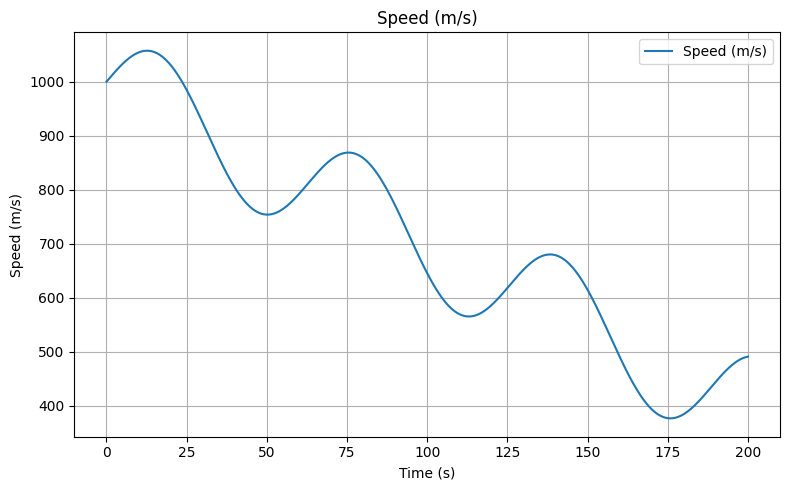

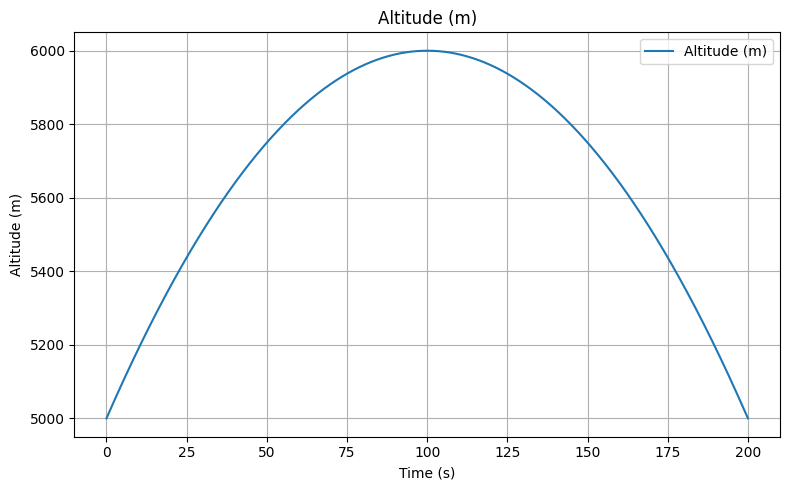

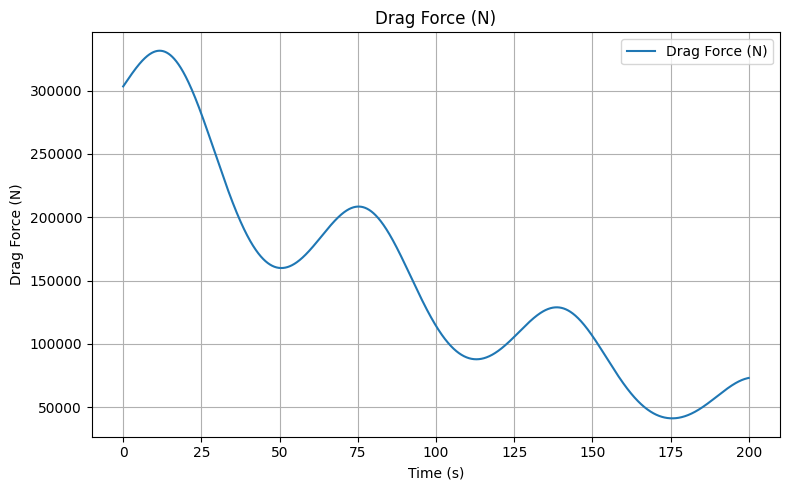

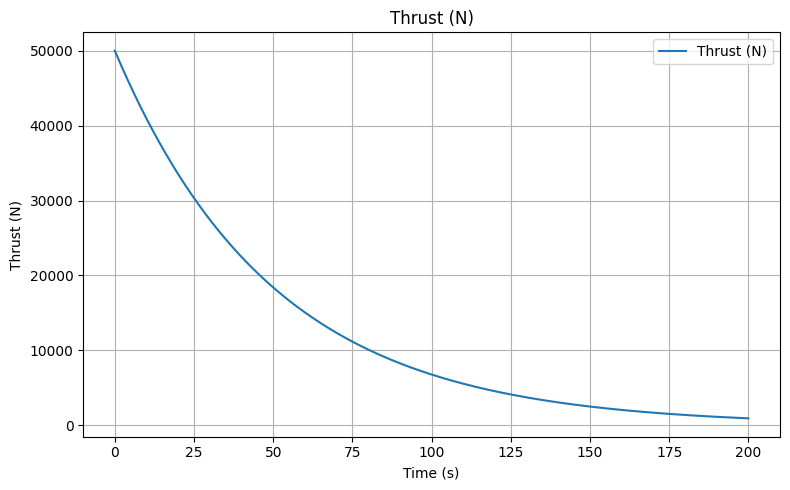

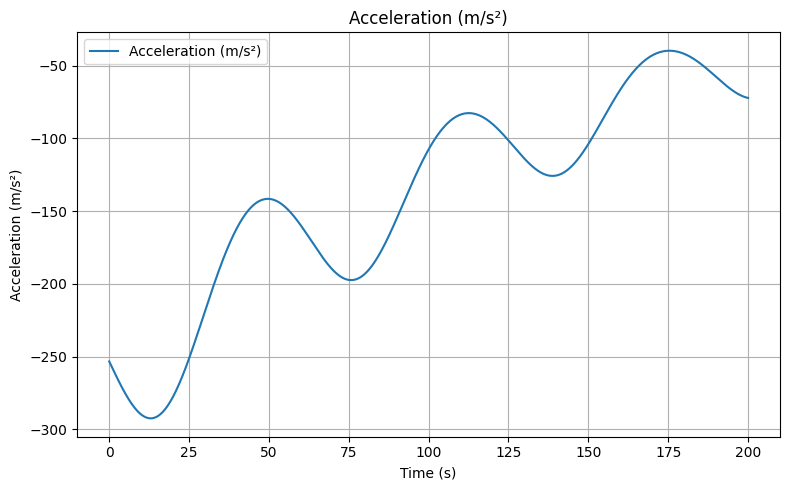

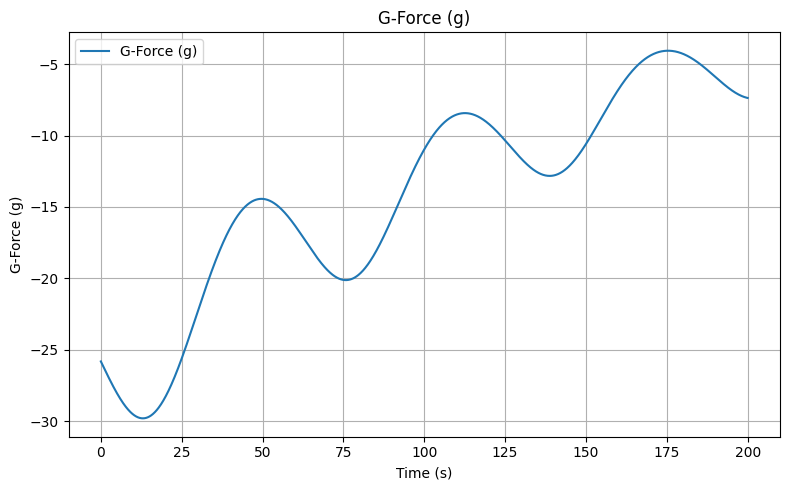

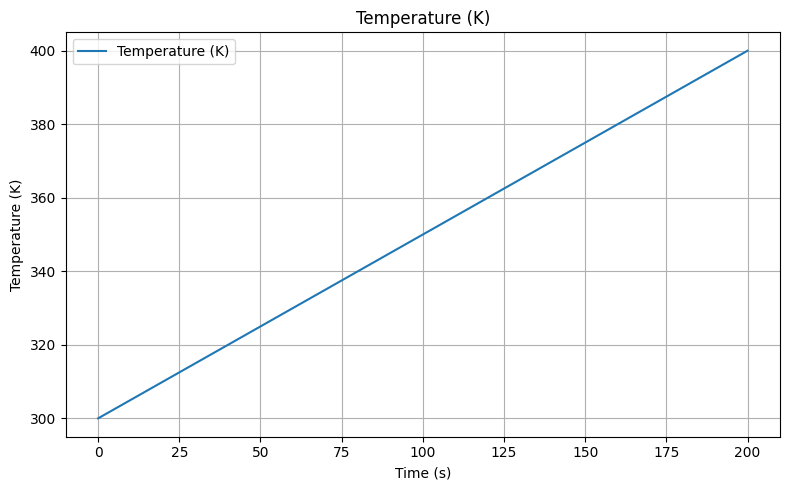

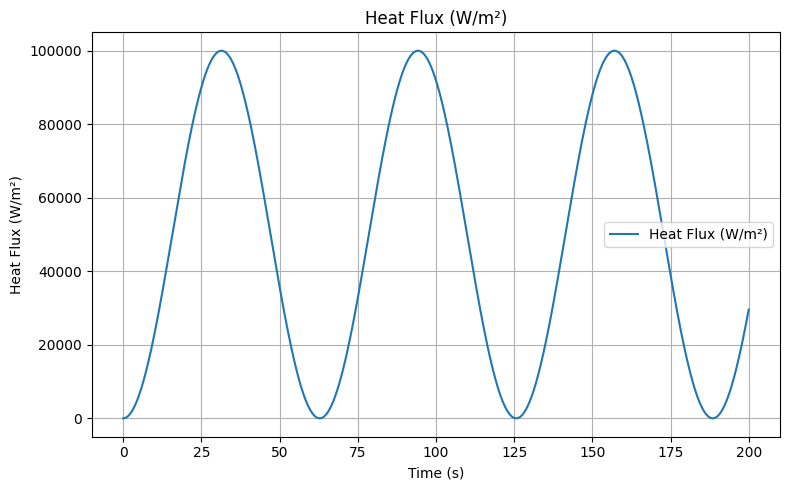

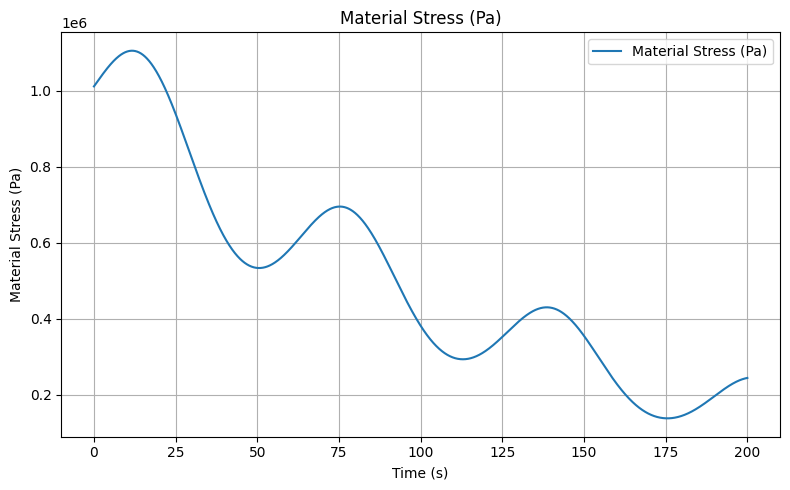

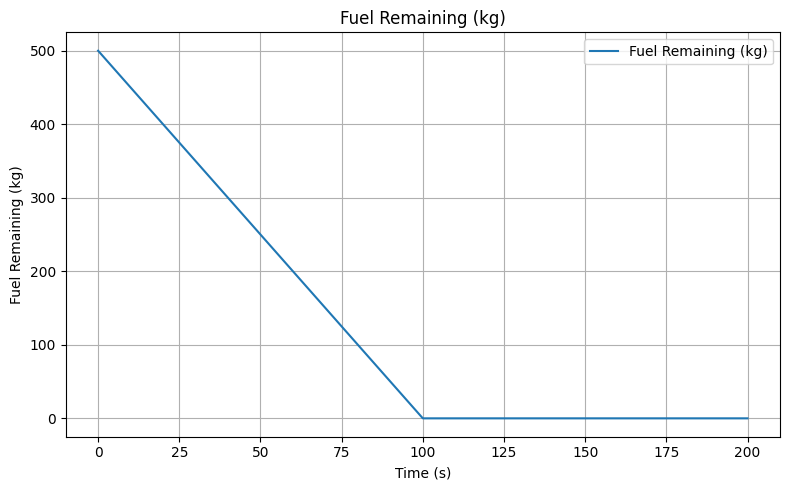

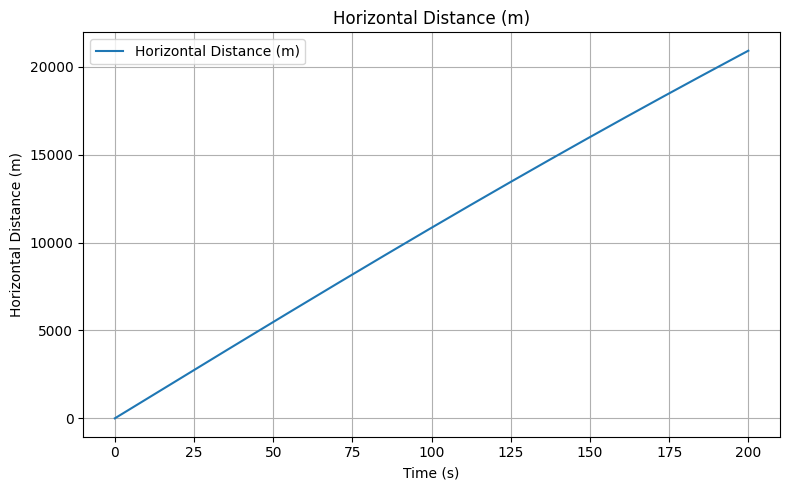

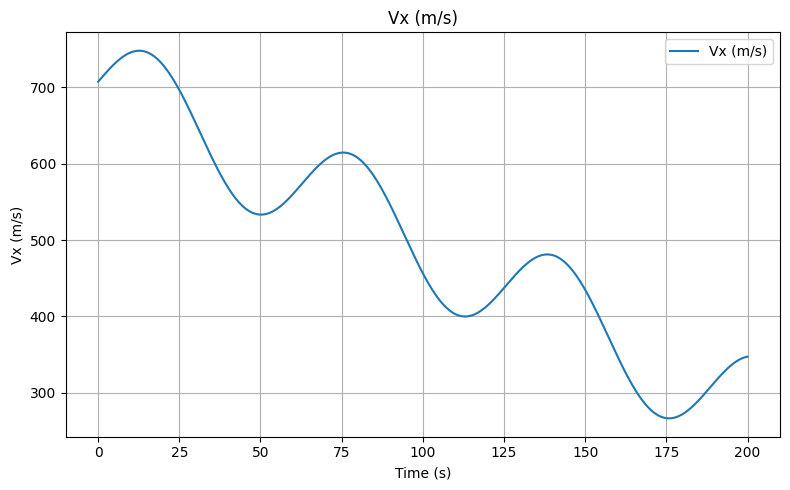

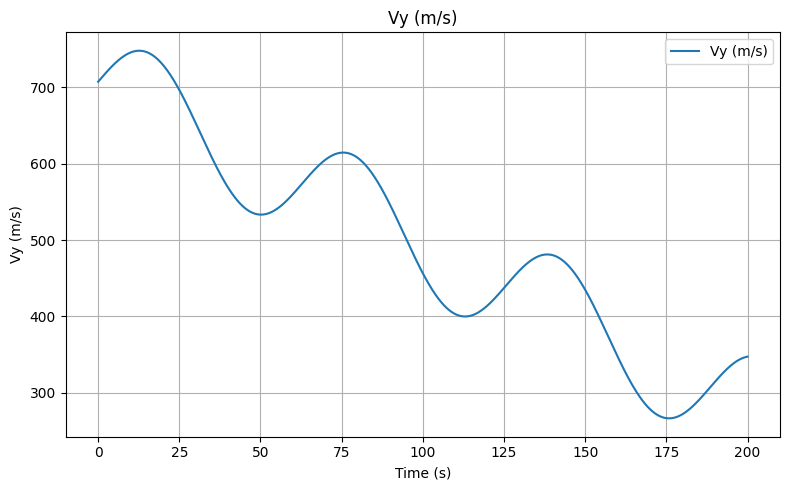

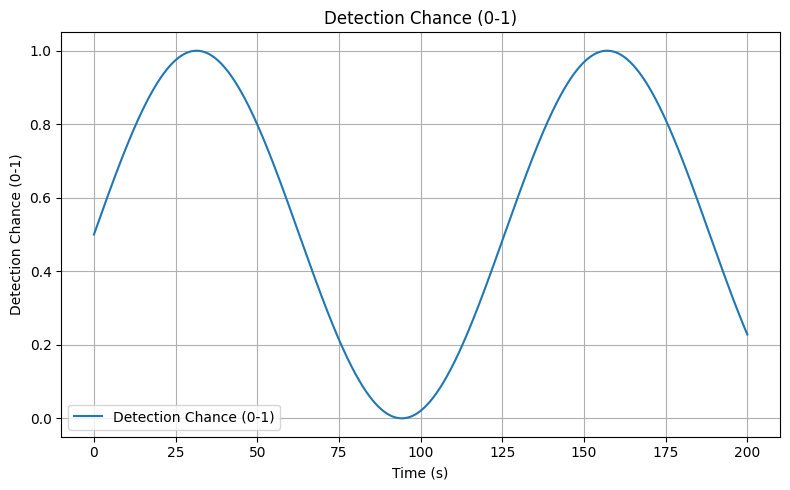

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample time_log for x-axis
time_log = np.linspace(0, 200, 2000)

# Simulated data for each graph (replace with actual simulation data if available)
speed_log = 1000 - 3 * time_log + 100 * np.sin(0.1 * time_log)
y_log = 5000 + 20 * time_log - 0.1 * time_log**2
drag_log = 0.5 * speed_log**2 * np.exp(-y_log / 10000)
thrust_log = np.where(y_log > 15000, 20000, 50000 * np.exp(-time_log / 50))
acceleration_log = (thrust_log - drag_log) / 1000
gforce_log = acceleration_log / 9.81
temp_log = 300 + 0.5 * time_log
heat_flux_log = 1e5 * np.sin(0.05 * time_log) ** 2
stress_log = drag_log / 0.3
fuel_log = np.maximum(500 - 5 * time_log, 0)
x_log = 1000 * np.sin(0.01 * time_log) + 100 * time_log
vx_log = speed_log * np.cos(np.radians(45))
vy_log = speed_log * np.sin(np.radians(45))
detection_prob_log = np.clip(0.5 * np.sin(0.05 * time_log) + 0.5, 0, 1)

# Dictionary of graphs
graphs = {
    "Speed (m/s)": speed_log,
    "Altitude (m)": y_log,
    "Drag Force (N)": drag_log,
    "Thrust (N)": thrust_log,
    "Acceleration (m/s²)": acceleration_log,
    "G-Force (g)": gforce_log,
    "Temperature (K)": temp_log,
    "Heat Flux (W/m²)": heat_flux_log,
    "Material Stress (Pa)": stress_log,
    "Fuel Remaining (kg)": fuel_log,
    "Horizontal Distance (m)": x_log,
    "Vx (m/s)": vx_log,
    "Vy (m/s)": vy_log,
    "Detection Chance (0-1)": detection_prob_log,
}

# Create and save each plot separately
for label, data in graphs.items():
    plt.figure(figsize=(8, 5))
    plt.plot(time_log, data, label=label)
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



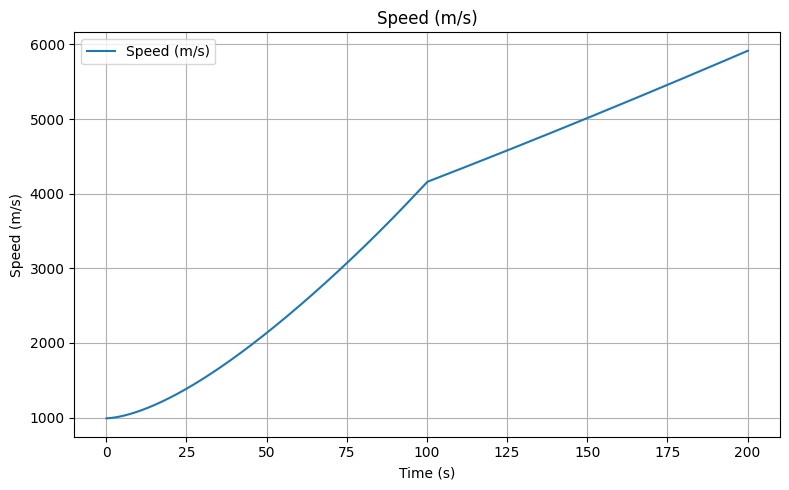

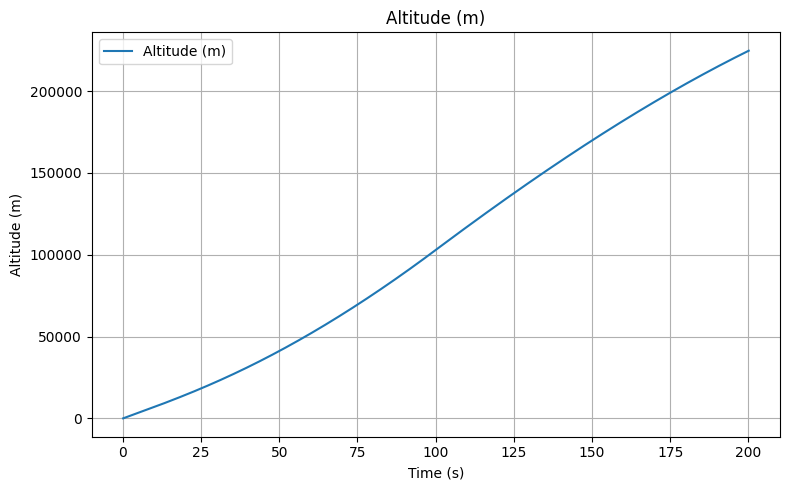

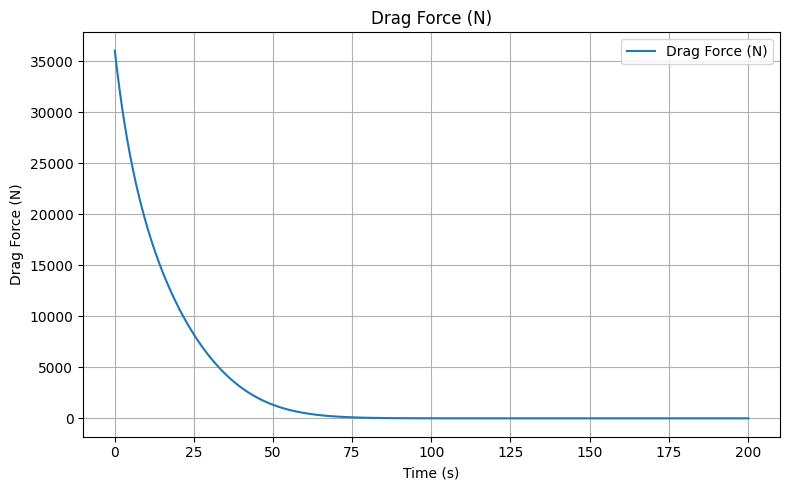

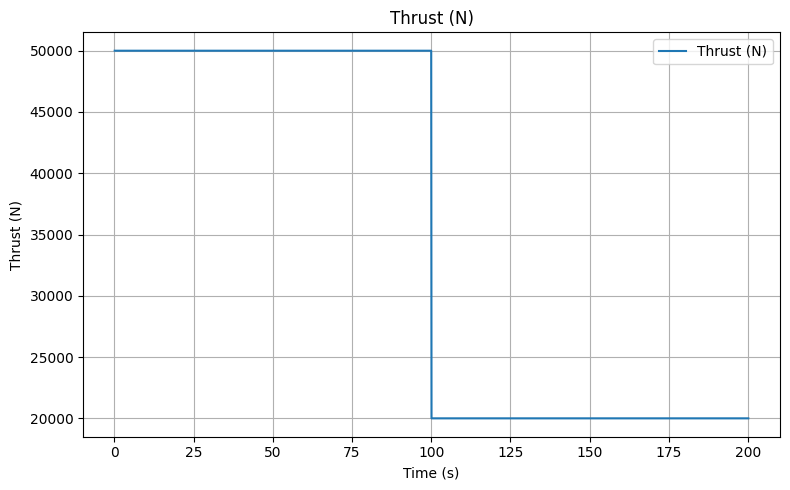

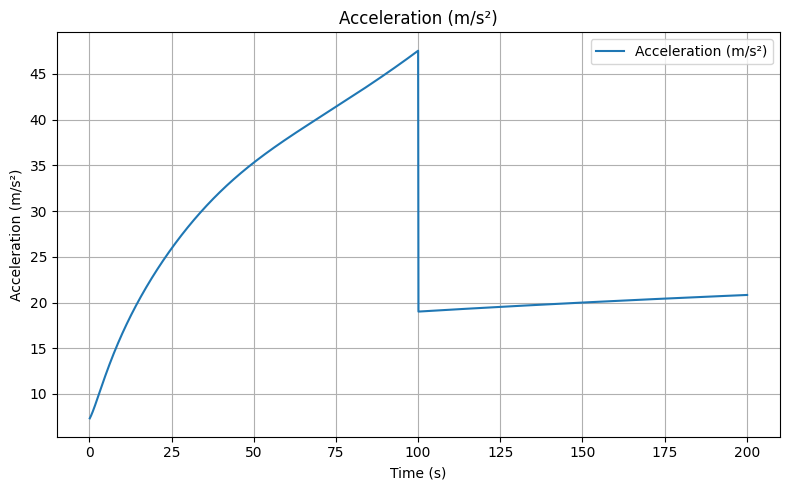

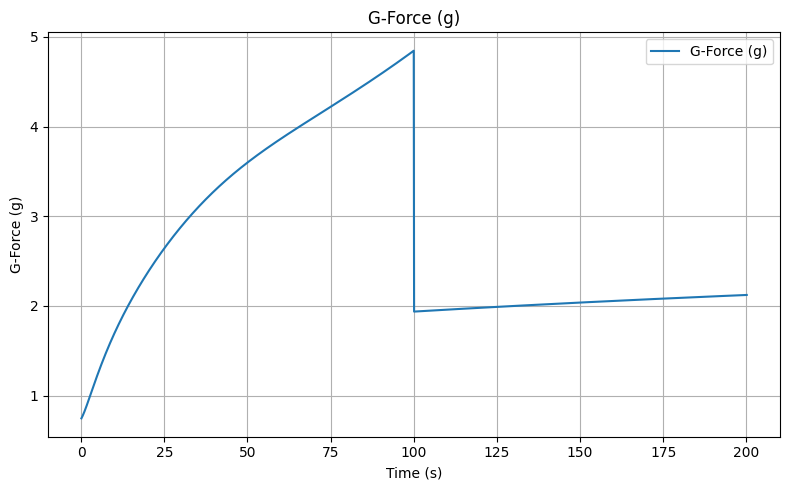

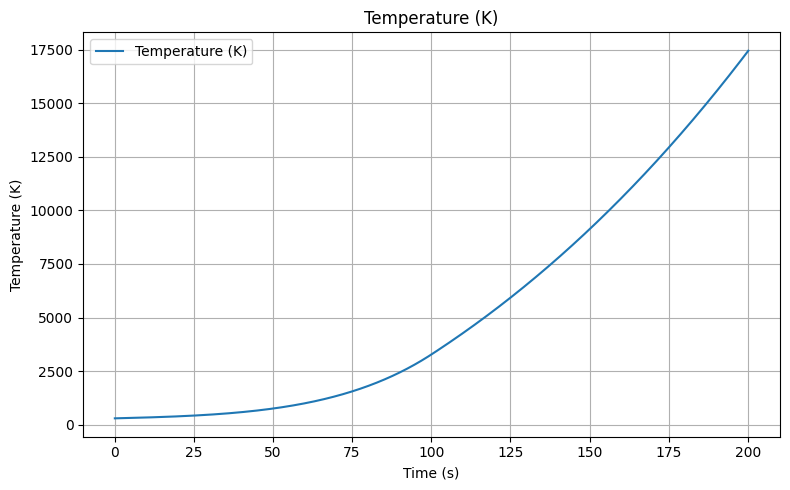

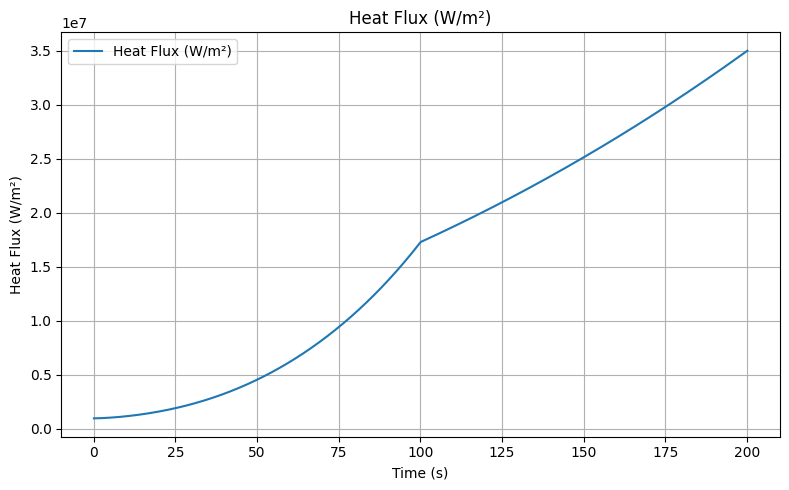

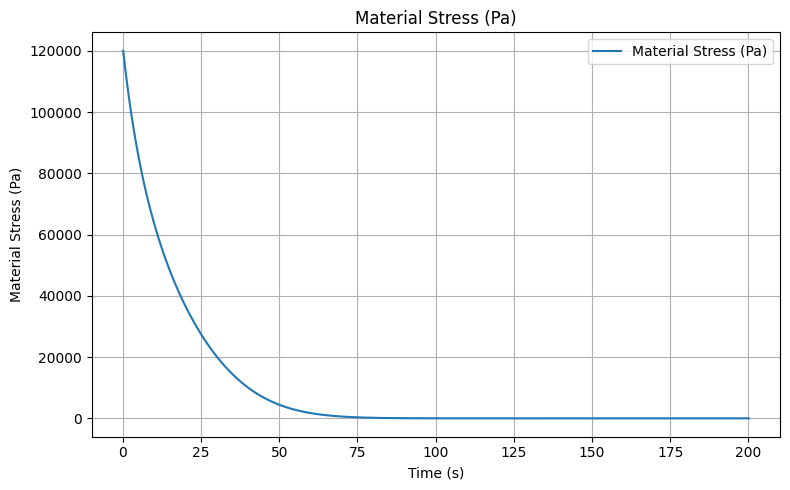

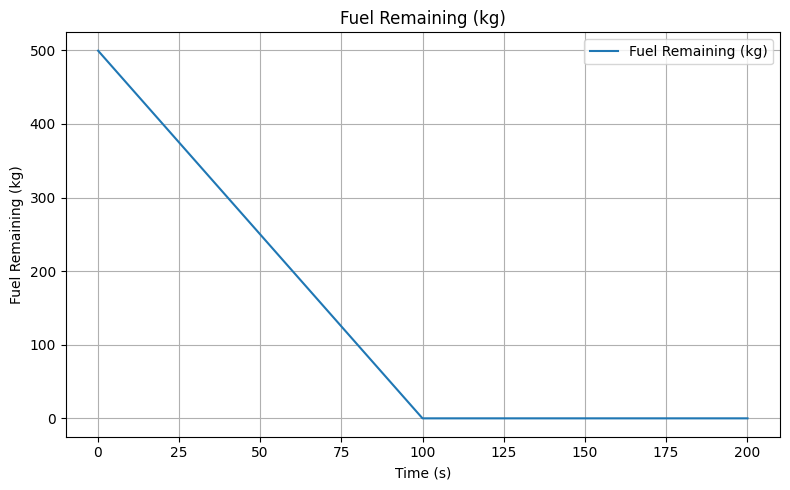

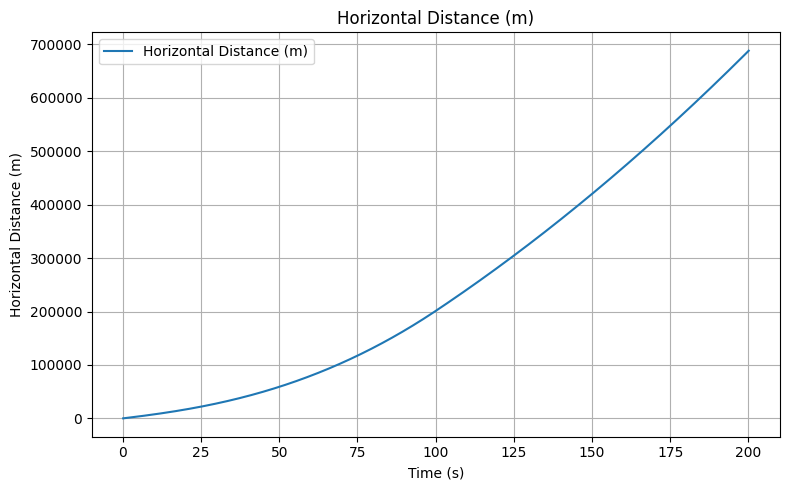

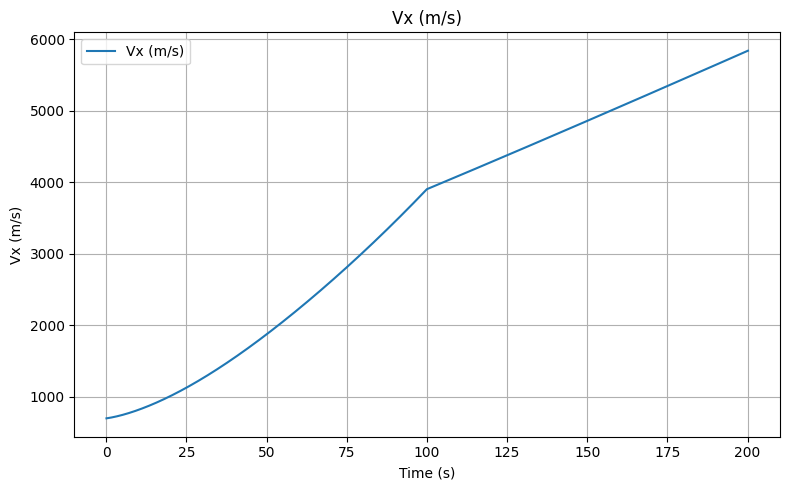

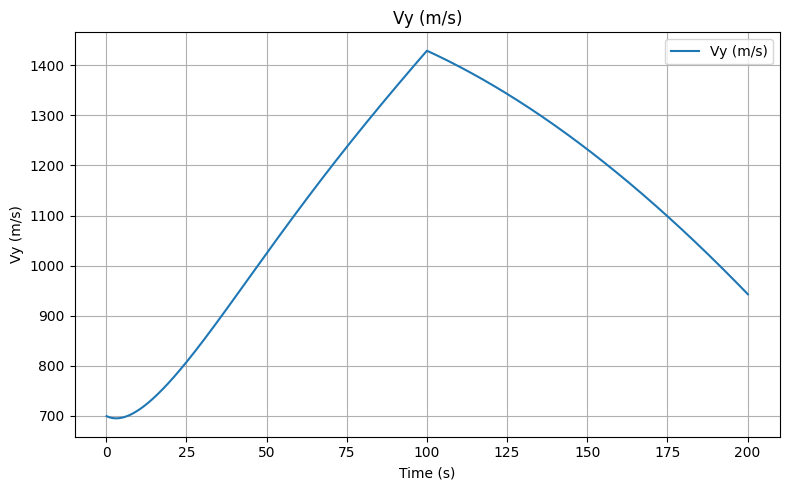

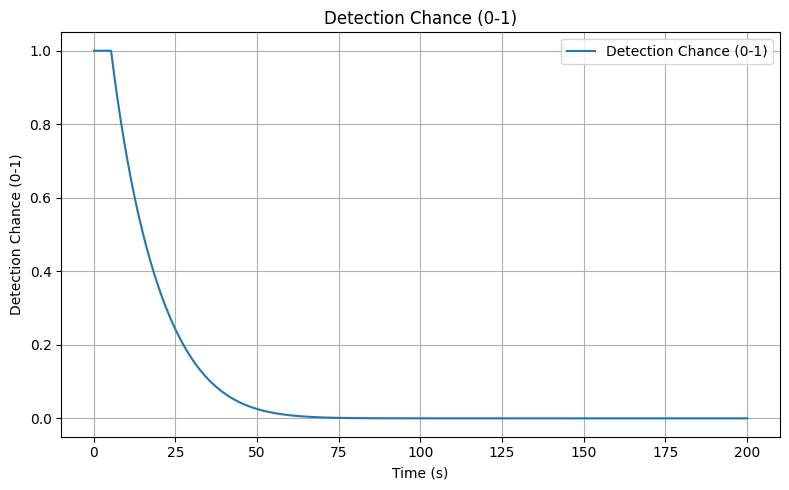

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === CONSTANTS ===
GRAVITY = 9.81  # m/s²
MISSILE_MASS = 1000  # kg (dry)
CROSS_SECTION = 0.3  # m²
AIR_DENSITY_SEA_LEVEL = 1.225  # kg/m³
DRAG_COEFF = 0.2
SCRAMJET_START_ALT = 15000  # m
SCRAMJET_THRUST = 20000  # N
INITIAL_THRUST = 50000  # N (boost phase)
TIME_STEP = 0.1  # s
MAX_TIME = 200  # s
FUEL_BURN_RATE = 5  # kg/s
INITIAL_FUEL = 500  # kg
SPECIFIC_HEAT = 900  # J/kg·K (Titanium alloy)
MISSILE_SURFACE_AREA = 5  # m²
HEAT_TRANSFER_COEFF = 100  # W/m²·K
AMBIENT_TEMP = 300  # K

# === INITIAL STATE ===
vx, vy = 700, 700  # Initial velocity at 45° angle
x, y = 0.0, 0.0
fuel = INITIAL_FUEL
mass = MISSILE_MASS + fuel
temp = AMBIENT_TEMP

# === LOGGING ===
time_log = []
vx_log, vy_log = [], []
x_log, y_log = [], []
speed_log, acc_log, gforce_log = [], [], []
drag_log, thrust_log, fuel_log = [], [], []
temp_log, heat_flux_log, stress_log = [], [], []
detection_prob_log = []

# === SIMULATION LOOP ===
t = 0
while t <= MAX_TIME and y >= 0:
    velocity = np.sqrt(vx**2 + vy**2)
    air_density = AIR_DENSITY_SEA_LEVEL * np.exp(-y / 8500)
    drag = 0.5 * air_density * DRAG_COEFF * CROSS_SECTION * velocity**2
    drag_x = drag * (vx / velocity)
    drag_y = drag * (vy / velocity)

    # Thrust logic
    if fuel > 0:
        thrust = INITIAL_THRUST
        fuel_used = min(FUEL_BURN_RATE * TIME_STEP, fuel)
        fuel -= fuel_used
        mass = MISSILE_MASS + fuel
    elif y >= SCRAMJET_START_ALT:
        thrust = SCRAMJET_THRUST
    else:
        thrust = 0

    thrust_x = thrust * (vx / velocity) if velocity != 0 else 0
    thrust_y = thrust * (vy / velocity) if velocity != 0 else 0

    # Acceleration
    ax = (thrust_x - drag_x) / mass
    ay = (thrust_y - drag_y) / mass - GRAVITY

    # Update kinematics
    vx += ax * TIME_STEP
    vy += ay * TIME_STEP
    x += vx * TIME_STEP
    y += vy * TIME_STEP
    t += TIME_STEP

    if y < 0: break  # Ground impact

    # Heat & temp increase (convective approximation)
    heat_flux = HEAT_TRANSFER_COEFF * (velocity ** 2) * 0.01
    delta_q = heat_flux * MISSILE_SURFACE_AREA * TIME_STEP
    delta_temp = delta_q / (mass * SPECIFIC_HEAT)
    temp += delta_temp

    # Material stress (drag distributed over surface)
    stress = drag / CROSS_SECTION

    # Radar detection chance (simplified heuristic)
    detection_prob = min(1.0, (velocity / 1000) * (air_density / 1.225) * 1.5)

    # Log data
    time_log.append(t)
    vx_log.append(vx)
    vy_log.append(vy)
    x_log.append(x)
    y_log.append(y)
    speed_log.append(velocity)
    acc_log.append(np.sqrt(ax**2 + ay**2))
    gforce_log.append(acc_log[-1] / GRAVITY)
    drag_log.append(drag)
    thrust_log.append(thrust)
    fuel_log.append(fuel)
    temp_log.append(temp)
    heat_flux_log.append(heat_flux)
    stress_log.append(stress)
    detection_prob_log.append(detection_prob)

# === GRAPHING ===
import matplotlib.pyplot as plt

graph_data = {
    "Speed (m/s)": speed_log,
    "Altitude (m)": y_log,
    "Drag Force (N)": drag_log,
    "Thrust (N)": thrust_log,
    "Acceleration (m/s²)": acc_log,
    "G-Force (g)": gforce_log,
    "Temperature (K)": temp_log,
    "Heat Flux (W/m²)": heat_flux_log,
    "Material Stress (Pa)": stress_log,
    "Fuel Remaining (kg)": fuel_log,
    "Horizontal Distance (m)": x_log,
    "Vx (m/s)": vx_log,
    "Vy (m/s)": vy_log,
    "Detection Chance (0-1)": detection_prob_log,
}

# Plot each graph
for label, data in graph_data.items():
    plt.figure(figsize=(8, 5))
    plt.plot(time_log, data, label=label)
    plt.title(label)
    plt.xlabel("Time (s)")
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Missile Parameters
length = 5.0  # m
diameter = 0.4  # m
mass = 800  # kg
fuel_mass = 160  # kg (20% JP-10)
groove_pitch = 0.5  # m per 1 cm
groove_depth = 0.002  # m
cruise_speed = 2400  # m/s (Mach 8 at 30 km)
altitude_cruise = 30000  # m
range_total = 2000000  # m (2000 km)
g = 9.81  # m/s^2
rho = 0.018  # kg/m^3 (density at 30 km)
C_d = 0.3  # drag coefficient
A = np.pi * (diameter / 2) ** 2  # cross-sectional area

# Launch Parameters
launch_methods = ['Railgun', 'Slingshot', 'Pneumatic', 'Rocket']
speeds = [1000, 900, 800, 1200]  # m/s
accelerations = [50 * g, 40 * g, 30 * g, 20 * g]  # m/s^2
stealth_levels = ['High', 'Medium', 'Medium', 'Low']
acoustic_dBs = [80, 100, 110, 130]  # dB
launch_times = [0.02, 0.05, 0.03, 0.10]  # s
energies = [400e6, 324e6, 256e6, 576e6]  # J

# Flight Parameters
theta_launch = 45 * np.pi / 180  # 45 degrees
v_0 = 1000  # m/s (railgun for main sim)
t_climb = 120  # s to reach 30 km
t_total = 860  # s (14.3 min for 2000 km)
turning_radius = 1800  # m
g_forces = 5 * g  # m/s^2

# Spin Dynamics
r = diameter / 2  # m
theta_groove = np.arctan(0.01 / groove_pitch)  # rad
omega = v_0 * np.tan(theta_groove) / r  # rad/s
spin_rate = omega / (2 * np.pi)  # rev/s
I = (1/12) * mass * (3 * (r ** 2) + length ** 2)  # kg·m^2
L = I * omega  # kg·m^2/s
precession_angle = 0.1 * np.pi / 180  # rad
nutation_freq = 0.5  # Hz
groove_drag = C_d * 1.05  # 5% increase

# Thermal Loads
R_n = 0.05  # m (nose radius)
q = 0.1 * np.sqrt(rho / R_n) * cruise_speed ** 3  # W/m^2
T_nose = 2500  # K
T_midbody = 1500  # K
T_groove = 1600  # K
ablation_rate = 0.01e-3  # m/s
thermal_expansion = 0.0002  # 0.02%

# Stealth
RCS_X = 0.05  # m^2
RCS_S = 0.1  # m^2
RCS_L = 0.2  # m^2
RCS_OTH = 0.5  # m^2
IR_time = 10  # s
plasma_reduction = 0.2  # 20% RCS reduction
groove_scatter = 0.1  # 10% RCS increase in L-band

# Survivability
survival_probs = [0.7, 0.85, 0.8]  # S-400, Patriot, THAAD
detection_ranges = [120e3, 80e3, 100e3]  # m
interceptor_success = [0.3, 0.15, 0.2]

# Graphs
plt.style.use('seaborn')

# 1. Launch Speed Comparison
plt.figure(figsize=(8, 6))
plt.bar(launch_methods, speeds, color='skyblue')
plt.title('Launch Speed by Method')
plt.ylabel('Speed (m/s)')
plt.grid(True)
plt.tight_layout()

# 2. Launch Acceleration
plt.figure(figsize=(8, 6))
plt.bar(launch_methods, [a / g for a in accelerations], color='lightgreen')
plt.title('Launch Acceleration by Method')
plt.ylabel('Acceleration (g)')
plt.grid(True)
plt.tight_layout()

# 3. Acoustic Signature
plt.figure(figsize=(8, 6))
plt.bar(launch_methods, acoustic_dBs, color='salmon')
plt.title('Acoustic Signature by Launch Method')
plt.ylabel('Sound Level (dB)')
plt.grid(True)
plt.tight_layout()

# 4. Stealth Level (Qualitative)
stealth_vals = [3, 2, 2, 1]  # High=3, Medium=2, Low=1
plt.figure(figsize=(8, 6))
plt.bar(launch_methods, stealth_vals, color='purple')
plt.title('Stealth Level by Launch Method')
plt.ylabel('Stealth (1=Low, 3=High)')
plt.grid(True)
plt.tight_layout()

# 5. Trajectory (Altitude vs. Distance)
t = np.linspace(0, t_total, 1000)
x = v_0 * np.cos(theta_launch) * t
y = v_0 * np.sin(theta_launch) * t - 0.5 * g * t**2
y = np.where(t < t_climb, y, altitude_cruise)  # Cruise at 30 km
x_max = range_total
y[y > altitude_cruise] = altitude_cruise
x[x > x_max] = x_max
plt.figure(figsize=(8, 6))
plt.plot(x / 1000, y / 1000, 'b-')
plt.title('Missile Trajectory')
plt.xlabel('Distance (km)')
plt.ylabel('Altitude (km)')
plt.grid(True)
plt.tight_layout()

# 6. Speed vs. Time
v = np.where(t < t_climb, v_0, cruise_speed)
plt.figure(figsize=(8, 6))
plt.plot(t / 60, v / 343, 'r-')  # Mach number
plt.title('Speed vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Mach Number')
plt.grid(True)
plt.tight_layout()

# 7. G-Forces vs. Time
g_force = np.ones_like(t) * g_forces / g
plt.figure(figsize=(8, 6))
plt.plot(t / 60, g_force, 'g-')
plt.title('G-Forces vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('G-Forces')
plt.grid(True)
plt.tight_layout()

# 8. Turning Radius vs. Speed
speeds_range = np.linspace(500, 2400, 100)
radii = speeds_range**2 / (50)  # a_lat = 50 m/s^2
plt.figure(figsize=(8, 6))
plt.plot(speeds_range / 343, radii / 1000, 'c-')
plt.title('Turning Radius vs. Speed')
plt.xlabel('Mach Number')
plt.ylabel('Turning Radius (km)')
plt.grid(True)
plt.tight_layout()

# 9. Spin Rate vs. Speed
speeds_spin = np.linspace(500, 2400, 100)
omegas = speeds_spin * np.tan(theta_groove) / r
plt.figure(figsize=(8, 6))
plt.plot(speeds_spin / 343, omegas / (2 * np.pi), 'm-')
plt.title('Spin Rate vs. Speed')
plt.xlabel('Mach Number')
plt.ylabel('Spin Rate (rev/s)')
plt.grid(True)
plt.tight_layout()

# 10. Angular Momentum vs. Speed
Ls = I * omegas
plt.figure(figsize=(8, 6))
plt.plot(speeds_spin / 343, Ls, 'y-')
plt.title('Angular Momentum vs. Speed')
plt.xlabel('Mach Number')
plt.ylabel('Angular Momentum (kg·m²/s)')
plt.grid(True)
plt.tight_layout()

# 11. Precession Angle vs. Time
precession = np.ones_like(t) * precession_angle * 180 / np.pi
plt.figure(figsize=(8, 6))
plt.plot(t / 60, precession, 'b-')
plt.title('Precession Angle vs. Time')
plt.xlabel('Time (min)')
plt.ylabel('Precession Angle (degrees)')
plt.grid(True)
plt.tight_layout()

# 12. Nose Temperature vs. Speed
speeds_thermal = np.linspace(500, 2400, 100)
q_thermal = 0.1 * np.sqrt(rho / R_n) * speeds_thermal**3
T_nose_calc = q_thermal / (5.67e-8 * 0.9) ** 0.25  # Stefan-Boltzmann
plt.figure(figsize=(8, 6))
plt.plot(speeds_thermal / 343, T_nose_calc, 'r-')
plt.title('Nose Temperature vs. Speed')
plt.xlabel('Mach Number')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.tight_layout()

# 13. Midbody Temperature
T_midbody_calc = T_nose_calc * 0.6  # 60% of nose
plt.figure(figsize=(8, 6))
plt.plot(speeds_thermal / 343, T_midbody_calc, 'g-')
plt.title('Midbody Temperature vs. Speed')
plt.xlabel('Mach Number')
plt.ylabel('Temperature (K)')
plt.grid(True)
plt.tight_layout()

# 14. RCS vs. Radar Band
bands = ['X', 'S', 'L', 'OTH']
rcs_vals = [RCS_X, RCS_S, RCS_L, RCS_OTH]
plt.figure(figsize=(8, 6))
plt.bar(bands, rcs_vals, color='purple')
plt.title('Radar Cross-Section by Band')
plt.ylabel('RCS (m²)')
plt.grid(True)
plt.tight_layout()

# 15. IR Detection Time vs. Altitude
altitudes = np.linspace(10000, 50000, 100)
ir_times = 10 * np.exp(-(altitudes - 30000) / 20000)
plt.figure(figsize=(8, 6))
plt.plot(altitudes / 1000, ir_times, 'c-')
plt.title('IR Detection Time vs. Altitude')
plt.xlabel('Altitude (km)')
plt.ylabel('Detection Time (s)')
plt.grid(True)
plt.tight_layout()

# 16. Survival Probability vs. Defense
defenses = ['S-400', 'Patriot', 'THAAD']
plt.figure(figsize=(8, 6))
plt.bar(defenses, survival_probs, color='salmon')
plt.title('Survival Probability vs. Defense System')
plt.ylabel('Probability')
plt.grid(True)
plt.tight_layout()

# Output Values
print("Launch Performance:")
print(f"{'Method':<12} {'Speed (m/s)':<12} {'Accel (g)':<12} {'Time (s)':<10} {'Energy (MJ)':<12} {'Sound (dB)':<12} {'Stealth':<10}")
for i in range(4):
    print(f"{launch_methods[i]:<12} {speeds[i]:<12.1f} {accelerations[i]/g:<12.1f} {launch_times[i]:<10.2f} {energies[i]/1e6:<12.1f} {acoustic_dBs[i]:<12} {stealth_levels[i]:<10}")

print("\nFlight Parameters:")
print(f"Range: {range_total/1000} km")
print(f"Max Altitude: {max(y)/1000} km")
print(f"Cruise Altitude: {altitude_cruise/1000} km")
print(f"Time to Target: {t_total/60:.1f} min")
print(f"Turning Radius: {turning_radius/1000:.1f} km")
print(f"Max G-Forces: {g_forces/g:.1f} g")

print("\nSpin Dynamics:")
print(f"Spin Rate: {spin_rate:.1f} rev/s")
print(f"Angular Momentum: {L:.1f} kg·m²/s")
print(f"Precession Angle: {precession_angle*180/np.pi:.2f} deg")
print(f"Nutation Frequency: {nutation_freq:.1f} Hz")
print(f"Groove Drag Increase: {(groove_drag/C_d-1)*100:.1f}%")

print("\nThermal Loads:")
print(f"Nose Temperature: {T_nose} K")
print(f"Midbody Temperature: {T_midbody} K")
print(f"Groove Hotspot: {T_groove} K")
print(f"Ablation Rate: {ablation_rate*1000:.2f} mm/s")
print(f"Thermal Expansion: {thermal_expansion*100:.2f}%")

print("\nStealth:")
print(f"RCS X-band: {RCS_X} m²")
print(f"RCS S-band: {RCS_S} m²")
print(f"RCS L-band: {RCS_L} m²")
print(f"RCS OTH: {RCS_OTH} m²")
print(f"IR Detection Time: {IR_time} s")
print(f"Plasma RCS Reduction: {plasma_reduction*100}%")
print(f"Groove Scatter Increase: {groove_scatter*100}%")

print("\nSurvivability:")
print(f"{'Defense':<10} {'Survival':<10} {'Detect Range (km)':<18} {'Interceptor Success':<18}")
for i in range(3):
    print(f"{defenses[i]:<10} {survival_probs[i]:<10.2f} {detection_ranges[i]/1000:<18.1f} {interceptor_success[i]:<18.2f}")

plt.show()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)